<div class="alert alert-info alertinfo" style="margin-top: 0px">
<h1>  Titanic - Exploratory data analysis </h1>
</div>

<div class="alert-success" style="margin-top: 0px">
<h1> Imports </h1>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

# basic
import pandas as pd
import numpy as np

# exploration only 
import time, datetime
import scipy.stats as ss
import data_explorer as de

# preprocessing
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn import model_selection
from sklearn.model_selection import train_test_split

# accuracy metrics
from sklearn.metrics import f1_score

# model for feature importance
import catboost
from catboost import CatBoostClassifier

# visualition
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.target import ClassBalance
from yellowbrick.features import ParallelCoordinates

<div class="alert-success" style="margin-top: 0px">
<h1> Data set </h1>
</div>

In [2]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<div class="alert-success" style="margin-top: 0px">
<h1> Target variable </h1>
</div>

In [3]:
# Separate target vs features
target = 'Survived'
y = df.loc[:, target]
classes = ["Not survived", "survived"]

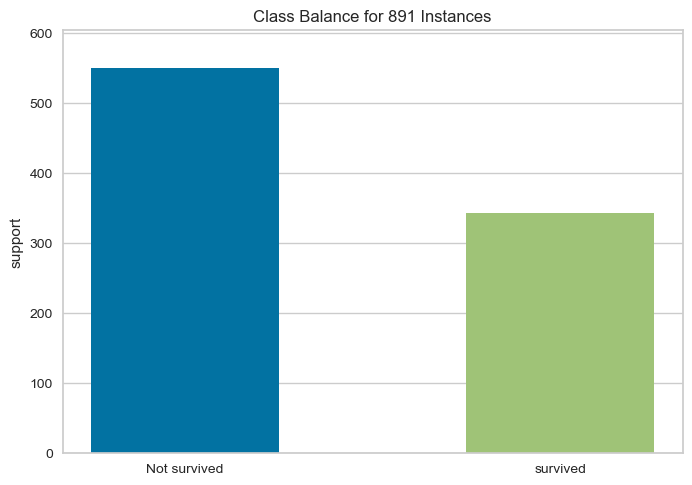

There are 891 records in this data set


In [4]:
visualizer = ClassBalance(labels=classes)
visualizer.fit(y) 
visualizer.show() 

print(f'There are {y.shape[0]} records in this data set')

<h3> We can see that our training set is imbalanced, here is a list of possible solutions to combat this </h3>
<h4> - changing scorring metrics to f-score (precision/recall) </h4>
<h4> - trying variety of algorithms - especially decision trees which frequently perform well on imbalanced data  </h4>
<h4> - trying different sampling techiques: <h4>
    
    - Oversample minority class, 
    - Undersample majority class 
    - Generate synthetic samples

<div class="alert-success" style="margin-top: 0px">
<h1> First glance </h1>
</div>

In [5]:
summary_table = de.summary_table(df)
summary_table

,Name,dtypes,Missing,Uniques
0,PassengerId,int64,0,891
1,Survived,int64,0,2
2,Pclass,int64,0,3
3,Name,object,0,891
4,Sex,object,0,2
5,Age,float64,177,88
6,SibSp,int64,0,7
7,Parch,int64,0,7
8,Ticket,object,0,681
9,Fare,float64,0,248


<h4> 'PassengerId' </h4> will not have any predictive power
<h4> 'Name', 'Ticket', 'Fare' and 'Cabin' </h4> have high cardinality so are candidates for feature engineering
<h4> 'Age', 'Cabin', and 'Embarked' </h4> have missing data

In [6]:
df.drop(['PassengerId'], axis = 1, inplace = True)

<div class="alert-success" style="margin-top: 0px">
<h1> Feature Engineering </h1>
</div>

# Name -> Title
We could have also engineered Surname but that would not help with cardinality reduction, we can extract a title which could be helpful

In [7]:
df[['Name']].head()

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"


In [8]:
# From name
def engineer_title(name: str):
    '''
    function engineers feature 'Title' from name
    
    Args:
        name: str
        
    Returns:
        title: str
    '''
    x = name.rsplit(",")
    title = x[1].strip().split(".")[0]
    return title

def clean_titles(old_title: str):
    '''
    Combines some titles together in order to reduce single cases (noise)
    
    Args:
        old_title: str
        
    Returns:
        new_title: str
    '''
    if old_title in ['Capt', 'Don', 'Jonkheer', 'Rev']:
        new_title = 'On_duty'
    elif old_title in ['Lady', 'Sir', 'the Countess','Dona','Col', 'Dr', 'Major','Mlle', 'Mme', 'Ms']:
        new_title = 'Rare'        
    else:
        new_title = old_title
    return new_title

df['Title'] = df['Name'].apply(lambda x: engineer_title(x))
df['Title'] = df['Title'].apply(lambda x: clean_titles(x))
df.drop(['Name'], axis = 1, inplace = True)
df[['Title']].head()

,Title
0,Mr
1,Mrs
2,Miss
3,Mrs
4,Mr


# Cabin -> Has_cabin
Too many missing data, however we can try to turn the 'missing' into feature itself

In [9]:
df[['Cabin']].head()

,Cabin
0,NaN
1,C85
2,NaN
3,C123
4,NaN


In [10]:
def engineer_cabin(cabin: str):
    '''
    function engineers feature 'Has_cabin' from Cabin
    if Cabin is missing, has_cabin = 0, else 1
    
    Args:
        cabin: str
        
    Returns:
        has_cabin: int
    '''
    if cabin == cabin:
        has_cabin = 1
    else:
        has_cabin = 0
    return has_cabin

df['Has_Cabin'] = df['Cabin'].apply(lambda x: engineer_cabin(x))
df.drop(['Cabin'], axis = 1, inplace = True)
df[['Has_Cabin']].head()

,Has_Cabin
0,0
1,1
2,0
3,1
4,0


# Ticket -> Survival_bonus, Survival Penalty
Families and friends will stay together and probably survive/die together, lets turn that into a feature

In [11]:
df[['Ticket']].head()

,Ticket
0,A/5 21171
1,PC 17599
2,STON/O2. 3101282
3,113803
4,373450


In [12]:
# currently build on the whole set - we will build one later based on training set only!
survival_tickets = []
death_tickets = []
for i, row in df.iterrows():
    if row[target] == 1:
        survival_tickets.append(row['Ticket'])
    else:
        death_tickets.append(row['Ticket'])
print(f'Survival Tickets: {len(survival_tickets)}, Death Tickets: {len(death_tickets)}')

Survival Tickets: 342, Death Tickets: 549


In [13]:
def engineer_survival_bonus(row):
    '''
    function engineers feature 'survival_bonus' from Ticket
    Assumption is made that people who share a cabin will stay together during crisis
    Survival_bonus is increased by 1 for each person with the same ticket number that survived
    Survival_penalty is increased by 1 for each person with the same ticket number that have died
    
    Args:
        row: single row of the data frame
        
    Returns:
        data frame with two new columns: 'survival_bonus' and 'survival_penalty'
    '''    
    
    ticket = row['Ticket']
    if ticket in survival_tickets:
        survival_bonus = len([x for x in death_tickets if x == ticket])
    else:
        survival_bonus = 0
    if ticket in death_tickets:
        survival_penalty = len([x for x in death_tickets if x == ticket])
    else:
        survival_penalty = 0
    row['survival_bonus'] = survival_bonus
    row['survival_penalty'] = survival_penalty
    return row

df = df.apply(engineer_survival_bonus, axis = 1)
df.drop(['Ticket'], axis = 1, inplace = True)

In [14]:
df[['survival_bonus', 'survival_penalty']].head()

,survival_bonus,survival_penalty
0,0,1
1,0,0
2,0,0
3,1,1
4,0,1


# Fare - > Fare Type
This feature could be improved with bining. We will use Elbow method to see how many bins should we use

In [15]:
df[['Fare']].head()

,Fare
0,7.2500
1,71.2833
2,7.9250
3,53.1000
4,8.0500


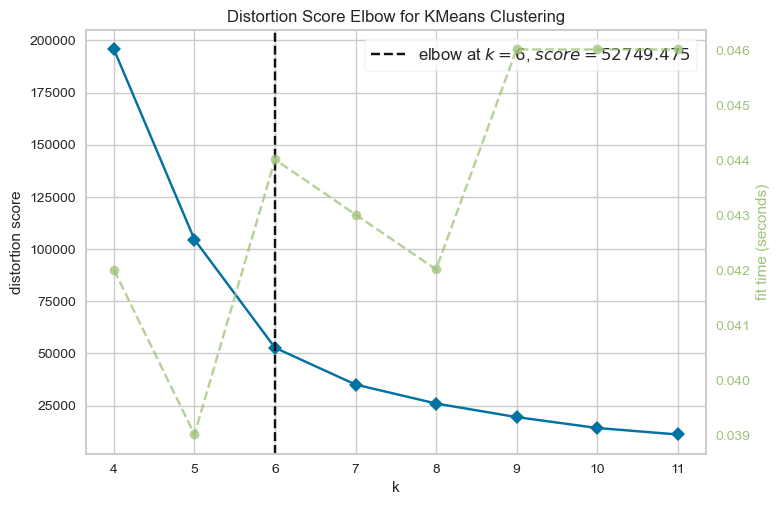

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

fare = df['Fare'].values
fare = fare.reshape(-1, 1)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(fare)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [17]:
labels = ['A', 'B', 'C', 'D', 'E', 'F']
df['Fare_type']=pd.qcut(df['Fare'], q=6,labels=labels)
df.drop(['Fare'], axis = 1, inplace = True)
df[['Fare_type']].head()

,Fare_type
0,A
1,F
2,B
3,F
4,B


<div class="alert-success" style="margin-top: 0px">
<h1> Missing data </h1>
</div>

### Age
More than 5% of data is missing, outliers and erroneus data are present - we will most likely not use this feature unless strong correlation to the target. Lets temporarily impute missing data

<AxesSubplot:>

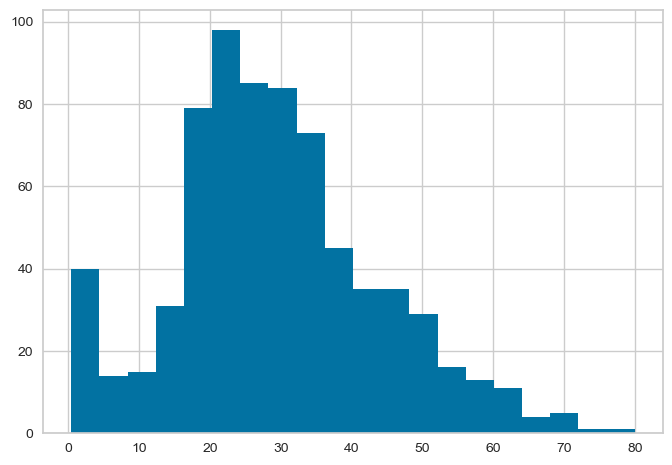

In [18]:
df.Age.hist(bins = 20)

### Embarked
<h4> There are only 2 missing values in feature 'Embarked' - we can find the trues values from: </h4>
<a href="https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html">click link: https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html</a>      
<h4> The missing value for both records is 'S' </h4>

In [19]:
df['Embarked'].replace(np.nan,'S',inplace=True)

<div class="alert-success" style="margin-top: 0px">
<h1> Class separability </h1>
</div>

<h4> we will temporarily label encode our categorical features to view class separability </h4>

In [20]:
# Separatating categorical and numerical features
cat_cols, num_cols = [], []
df = df.apply(lambda x: x.astype("category") if x.dtype == "O" else x)

for feature in df.columns:
    if df[feature].dtype == 'category':
        cat_cols.append(feature)
    else:
        num_cols.append(feature)
            
df1 = df[num_cols]
df2 = df[cat_cols]
for feature in df2.columns:
    label_encoder = preprocessing.LabelEncoder()
    df2[feature] = label_encoder.fit_transform(df2[feature])

view = pd.merge(df2, df1, left_index=True, right_index=True)            

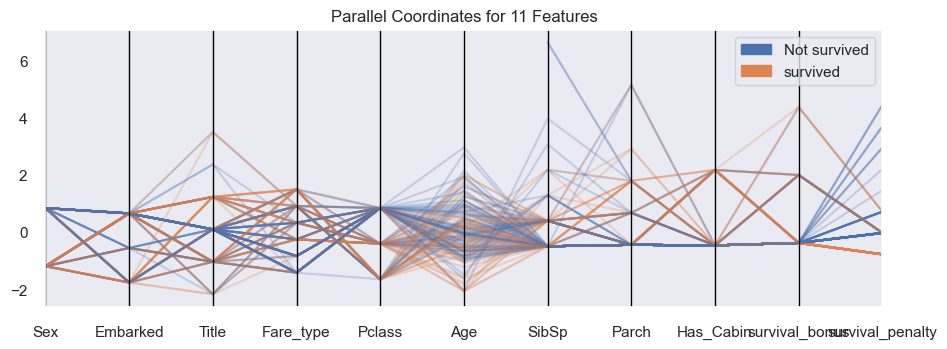

<AxesSubplot:title={'center':'Parallel Coordinates for 11 Features'}>

In [21]:
features = [x for x in view.columns if x != target]
preview = view[features]

sns.set(font_scale=1)
visualizer = ParallelCoordinates(classes=classes, features=features, sample=0.20, shuffle=True, normalize='standard', size=(1080, 360))
visualizer.fit_transform(preview, y)
visualizer.show()

#### Age seem the have the lowest class separability, together with missing values, extremes and errors it will not be a good predictor

<div class="alert-success" style="margin-top: 0px">
<h1> Feature Selection </h1>
</div>

# Model 1 

In [22]:
df = pd.read_csv('train.csv')
X = df.loc[:, df.columns != target]
y = df.loc[:, target]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
X_train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
331,332,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S
733,734,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S
382,383,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S
704,705,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S
813,814,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
106,107,3,"Salkjelsvik, Miss. Anna Kristine",female,21.0,0,0,343120,7.6500,NaN,S
270,271,1,"Cairns, Mr. Alexander",male,NaN,0,0,113798,31.0000,NaN,S
860,861,3,"Hansen, Mr. Claus Peter",male,41.0,2,0,350026,14.1083,NaN,S
435,436,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0000,B96 B98,S


In [24]:
# built only on training set
temp = pd.merge(X_train, y_train, left_index=True, right_index=True)
survival_tickets = []
death_tickets = []
for i, row in temp.iterrows():
    if row[target] == 1:
        survival_tickets.append(row['Ticket'])
    else:
        death_tickets.append(row['Ticket'])
print(f'Survival Tickets: {len(survival_tickets)}, Death Tickets: {len(death_tickets)}')

Survival Tickets: 268, Death Tickets: 444


In [25]:
def transform(df):
    '''
    function that transforms training set and test set in the same way
    this specific function:
    
    - drops Passenger ID
    - creates a 'Title' feature and drops the 'Name'
    - creates 'Has Cabin' and drops 'Cabin'
    - creates survival bonus/penulty and drops 'Ticket'
    - drops 'Fare' and 'Age'
    - replaces missing values for 'Embarked'
    
    Args:
        df
        
    Returns:
        df with new features
    '''
    df.drop(['PassengerId'], axis = 1, inplace = True)
    df['Title'] = df['Name'].apply(lambda x: engineer_title(x))
    df['Title'] = df['Title'].apply(lambda x: clean_titles(x))
    df.drop(['Name'], axis = 1, inplace = True)
    df['Has_Cabin'] = df['Cabin'].apply(lambda x: engineer_cabin(x))
    df.drop(['Cabin'], axis = 1, inplace = True)
    df = df.apply(engineer_survival_bonus, axis = 1)
    df.drop(['Ticket'], axis = 1, inplace = True)
    df.drop(['Fare'], axis = 1, inplace = True)
    df.drop(['Age'], axis = 1, inplace = True)
    df['Embarked'].replace(np.nan,'S',inplace=True)
    return df

In [26]:
X_train = transform(X_train)
X_test = transform(X_test)
X_train.head()

,Pclass,Sex,SibSp,Parch,Embarked,Title,Has_Cabin,survival_bonus,survival_penalty
331,1,male,0,0,S,Mr,1,0,1
733,2,male,0,0,S,Mr,0,0,1
382,3,male,0,0,S,Mr,0,0,1
704,3,male,1,0,S,Mr,0,0,1
813,3,female,4,2,S,Miss,0,0,6


In [27]:
features = list(X_train.columns)
cat_features = de.get_cat_features(X_train)

model_1 = CatBoostClassifier(task_type = 'GPU', iterations = 1000, eval_metric = 'F1')
model_1.fit(X_train, y_train, cat_features = cat_features, plot = True, eval_set = (X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.073293
0:	learn: 0.9718574	test: 0.5982143	best: 0.5982143 (0)	total: 41ms	remaining: 41s
1:	learn: 0.9694656	test: 0.5919283	best: 0.5982143 (0)	total: 74.6ms	remaining: 37.2s
2:	learn: 0.9694656	test: 0.5919283	best: 0.5982143 (0)	total: 108ms	remaining: 36s
3:	learn: 0.9694656	test: 0.5919283	best: 0.5982143 (0)	total: 144ms	remaining: 36s
4:	learn: 0.9694656	test: 0.5919283	best: 0.5982143 (0)	total: 178ms	remaining: 35.4s
5:	learn: 0.9694656	test: 0.5919283	best: 0.5982143 (0)	total: 208ms	remaining: 34.5s
6:	learn: 0.9694656	test: 0.5919283	best: 0.5982143 (0)	total: 241ms	remaining: 34.2s
7:	learn: 0.9694656	test: 0.5919283	best: 0.5982143 (0)	total: 277ms	remaining: 34.4s
8:	learn: 0.9714286	test: 0.5919283	best: 0.5982143 (0)	total: 311ms	remaining: 34.3s
9:	learn: 0.9694656	test: 0.5919283	best: 0.5982143 (0)	total: 341ms	remaining: 33.8s
10:	learn: 0.9714286	test: 0.5919283	best: 0.5982143 (0)	total: 376ms	remaining: 33.8s
11:	learn: 0.9714286	test: 0.

100:	learn: 0.9850187	test: 0.5982143	best: 0.5982143 (0)	total: 3.28s	remaining: 29.2s
101:	learn: 0.9850187	test: 0.5982143	best: 0.5982143 (0)	total: 3.32s	remaining: 29.2s
102:	learn: 0.9850187	test: 0.5982143	best: 0.5982143 (0)	total: 3.35s	remaining: 29.2s
103:	learn: 0.9850187	test: 0.5982143	best: 0.5982143 (0)	total: 3.38s	remaining: 29.2s
104:	learn: 0.9850187	test: 0.5982143	best: 0.5982143 (0)	total: 3.42s	remaining: 29.2s
105:	learn: 0.9850187	test: 0.5982143	best: 0.5982143 (0)	total: 3.45s	remaining: 29.1s
106:	learn: 0.9850187	test: 0.5982143	best: 0.5982143 (0)	total: 3.48s	remaining: 29.1s
107:	learn: 0.9869159	test: 0.6044444	best: 0.6044444 (107)	total: 3.52s	remaining: 29.1s
108:	learn: 0.9887640	test: 0.6044444	best: 0.6044444 (107)	total: 3.56s	remaining: 29.1s
109:	learn: 0.9887640	test: 0.6044444	best: 0.6044444 (107)	total: 3.6s	remaining: 29.1s
110:	learn: 0.9887640	test: 0.6044444	best: 0.6044444 (107)	total: 3.63s	remaining: 29.1s
111:	learn: 0.9887640	tes

192:	learn: 0.9943925	test: 0.6044444	best: 0.6044444 (107)	total: 6.57s	remaining: 27.4s
193:	learn: 0.9943925	test: 0.6044444	best: 0.6044444 (107)	total: 6.6s	remaining: 27.4s
194:	learn: 0.9943925	test: 0.6044444	best: 0.6044444 (107)	total: 6.64s	remaining: 27.4s
195:	learn: 0.9943925	test: 0.6044444	best: 0.6044444 (107)	total: 6.67s	remaining: 27.4s
196:	learn: 0.9943925	test: 0.6044444	best: 0.6044444 (107)	total: 6.71s	remaining: 27.4s
197:	learn: 0.9943925	test: 0.6044444	best: 0.6044444 (107)	total: 6.75s	remaining: 27.3s
198:	learn: 0.9943925	test: 0.6044444	best: 0.6044444 (107)	total: 6.78s	remaining: 27.3s
199:	learn: 0.9943925	test: 0.6044444	best: 0.6044444 (107)	total: 6.81s	remaining: 27.3s
200:	learn: 0.9943925	test: 0.6044444	best: 0.6044444 (107)	total: 6.85s	remaining: 27.2s
201:	learn: 0.9943925	test: 0.6044444	best: 0.6044444 (107)	total: 6.89s	remaining: 27.2s
202:	learn: 0.9943925	test: 0.6044444	best: 0.6044444 (107)	total: 6.92s	remaining: 27.2s
203:	learn:

285:	learn: 0.9962547	test: 0.6044444	best: 0.6044444 (107)	total: 9.84s	remaining: 24.6s
286:	learn: 0.9962547	test: 0.6044444	best: 0.6044444 (107)	total: 9.88s	remaining: 24.5s
287:	learn: 0.9962547	test: 0.6044444	best: 0.6044444 (107)	total: 9.91s	remaining: 24.5s
288:	learn: 0.9962547	test: 0.6044444	best: 0.6044444 (107)	total: 9.95s	remaining: 24.5s
289:	learn: 0.9962547	test: 0.6044444	best: 0.6044444 (107)	total: 9.98s	remaining: 24.4s
290:	learn: 0.9962547	test: 0.6044444	best: 0.6044444 (107)	total: 10s	remaining: 24.4s
291:	learn: 0.9962547	test: 0.6044444	best: 0.6044444 (107)	total: 10.1s	remaining: 24.4s
292:	learn: 0.9962547	test: 0.6044444	best: 0.6044444 (107)	total: 10.1s	remaining: 24.3s
293:	learn: 0.9962547	test: 0.6044444	best: 0.6044444 (107)	total: 10.1s	remaining: 24.3s
294:	learn: 0.9962547	test: 0.6044444	best: 0.6044444 (107)	total: 10.2s	remaining: 24.3s
295:	learn: 0.9962547	test: 0.6044444	best: 0.6044444 (107)	total: 10.2s	remaining: 24.2s
296:	learn: 

378:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 13s	remaining: 21.2s
379:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 13s	remaining: 21.2s
380:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 13s	remaining: 21.2s
381:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 13.1s	remaining: 21.1s
382:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 13.1s	remaining: 21.1s
383:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 13.1s	remaining: 21.1s
384:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 13.2s	remaining: 21.1s
385:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 13.2s	remaining: 21s
386:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 13.2s	remaining: 21s
387:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 13.3s	remaining: 21s
388:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 13.3s	remaining: 20.9s
389:	learn: 1.0000000	

476:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 16.3s	remaining: 17.8s
477:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 16.3s	remaining: 17.8s
478:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 16.3s	remaining: 17.8s
479:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 16.4s	remaining: 17.7s
480:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 16.4s	remaining: 17.7s
481:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 16.4s	remaining: 17.6s
482:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 16.4s	remaining: 17.6s
483:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 16.5s	remaining: 17.6s
484:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 16.5s	remaining: 17.5s
485:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 16.5s	remaining: 17.5s
486:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 16.5s	remaining: 17.4s
487:	learn

571:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 19.2s	remaining: 14.4s
572:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 19.2s	remaining: 14.3s
573:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 19.3s	remaining: 14.3s
574:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 19.3s	remaining: 14.3s
575:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 19.3s	remaining: 14.2s
576:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 19.3s	remaining: 14.2s
577:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 19.4s	remaining: 14.1s
578:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 19.4s	remaining: 14.1s
579:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 19.4s	remaining: 14.1s
580:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 19.5s	remaining: 14s
581:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 19.5s	remaining: 14s
582:	learn: 1.

664:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 22.2s	remaining: 11.2s
665:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 22.2s	remaining: 11.2s
666:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 22.3s	remaining: 11.1s
667:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 22.3s	remaining: 11.1s
668:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 22.3s	remaining: 11.1s
669:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 22.4s	remaining: 11s
670:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 22.4s	remaining: 11s
671:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 22.4s	remaining: 11s
672:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 22.5s	remaining: 10.9s
673:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 22.5s	remaining: 10.9s
674:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 22.5s	remaining: 10.9s
675:	learn: 1.00

757:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 24.9s	remaining: 7.95s
758:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 24.9s	remaining: 7.92s
759:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 25s	remaining: 7.89s
760:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 25s	remaining: 7.87s
761:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 25.1s	remaining: 7.83s
762:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 25.1s	remaining: 7.8s
763:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 25.1s	remaining: 7.77s
764:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 25.2s	remaining: 7.73s
765:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 25.2s	remaining: 7.7s
766:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 25.2s	remaining: 7.67s
767:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 25.3s	remaining: 7.63s
768:	learn: 1.00

853:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 27.8s	remaining: 4.75s
854:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 27.8s	remaining: 4.72s
855:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 27.8s	remaining: 4.68s
856:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 27.9s	remaining: 4.65s
857:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 27.9s	remaining: 4.62s
858:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 27.9s	remaining: 4.58s
859:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 27.9s	remaining: 4.55s
860:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 28s	remaining: 4.51s
861:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 28s	remaining: 4.48s
862:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 28s	remaining: 4.45s
863:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 28.1s	remaining: 4.42s
864:	learn: 1.00

950:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 30.6s	remaining: 1.58s
951:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 30.6s	remaining: 1.54s
952:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 30.7s	remaining: 1.51s
953:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 30.7s	remaining: 1.48s
954:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 30.7s	remaining: 1.45s
955:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 30.8s	remaining: 1.42s
956:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 30.8s	remaining: 1.38s
957:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 30.8s	remaining: 1.35s
958:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 30.9s	remaining: 1.32s
959:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 30.9s	remaining: 1.29s
960:	learn: 1.0000000	test: 0.6044444	best: 0.6044444 (107)	total: 30.9s	remaining: 1.25s
961:	learn

,imp,col
6,0.018540,Has_Cabin
3,0.141069,Parch
0,0.553290,Pclass
4,0.916226,Embarked
2,1.865856,SibSp
1,2.501622,Sex
5,2.720627,Title
7,17.644467,survival_bonus
8,73.638303,survival_penalty


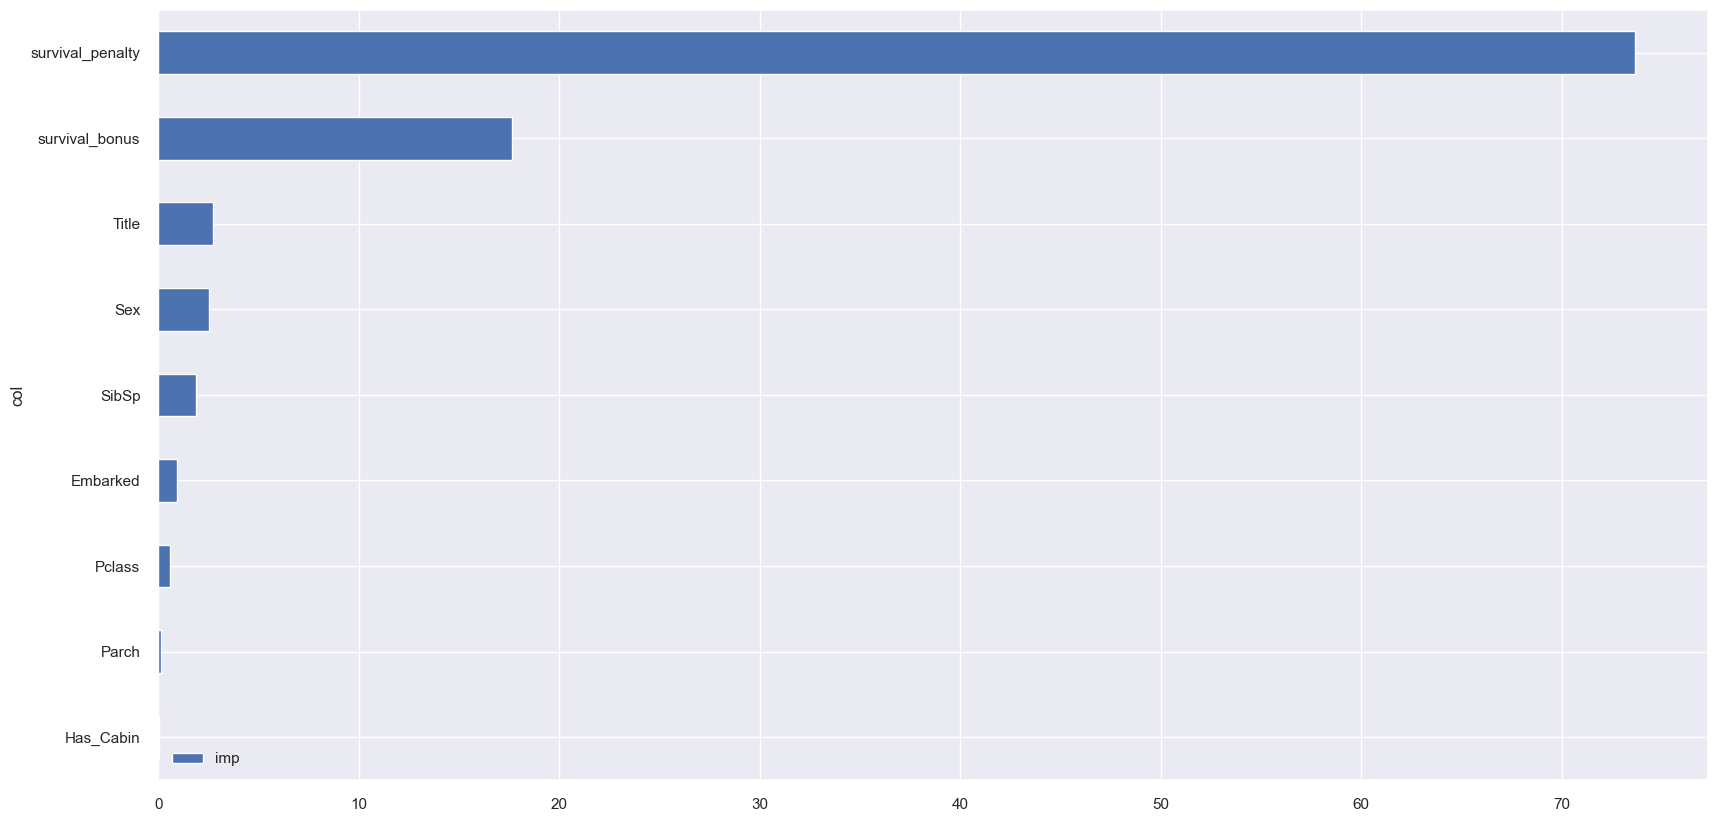

In [28]:
def feature_importance(model, data):
    '''
    Function to show which features are most important in the model.
    
    Args:
        model: catboost model
        data: X_train
        
    Return:
        Feature importance
    '''
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp

feature_importance(model_1,X_train)

In [29]:
print('Training Accuracy: ', f1_score(y_train, model_1.predict(X_train)))
print('Testing Accuracy: ', f1_score(y_test, model_1.predict(X_test)))

Training Accuracy:  0.9851301115241636
Testing Accuracy:  0.6044444444444445


### This model is overfitting! Biggest culprit -  survival_penalty - we need to bring the ticket back

# Model 2 

In [30]:
df = pd.read_csv('train.csv')
X = df.loc[:, df.columns != target]
y = df.loc[:, target]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
def transform_2(df):
    '''
    function that transforms training set and test set in the same way
    this specific function:
    
    - drops Passenger ID
    - creates a 'Title' feature and drops the 'Name'
    - creates 'Has Cabin' and drops 'Cabin'
    - drops 'Fare' and 'Age'
    - replaces missing values for 'Embarked'
    
    Args:
        df
        
    Returns:
        df with new features
    '''
    df.drop(['PassengerId'], axis = 1, inplace = True)
    df['Title'] = df['Name'].apply(lambda x: engineer_title(x))
    df['Title'] = df['Title'].apply(lambda x: clean_titles(x))
    df.drop(['Name'], axis = 1, inplace = True)
    df['Has_Cabin'] = df['Cabin'].apply(lambda x: engineer_cabin(x))
    df.drop(['Cabin'], axis = 1, inplace = True)
    df.drop(['Fare'], axis = 1, inplace = True)
    df.drop(['Age'], axis = 1, inplace = True)
    df['Embarked'].replace(np.nan,'S',inplace=True)
    return df

In [32]:
X_train = transform_2(X_train)
X_test = transform_2(X_test)
X_train.head()

,Pclass,Sex,SibSp,Parch,Ticket,Embarked,Title,Has_Cabin
331,1,male,0,0,113043,S,Mr,1
733,2,male,0,0,28425,S,Mr,0
382,3,male,0,0,STON/O 2. 3101293,S,Mr,0
704,3,male,1,0,350025,S,Mr,0
813,3,female,4,2,347082,S,Miss,0


In [33]:
features = list(X_train.columns)
cat_features = de.get_cat_features(X_train)

model_2 = CatBoostClassifier(task_type = 'GPU', iterations = 1000, eval_metric = 'F1')
model_2.fit(X_train, y_train, cat_features = cat_features, plot = True, eval_set = (X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.073293
0:	learn: 0.7586207	test: 0.7837838	best: 0.7837838 (0)	total: 35ms	remaining: 35s
1:	learn: 0.7586207	test: 0.7837838	best: 0.7837838 (0)	total: 71.2ms	remaining: 35.5s
2:	learn: 0.7462687	test: 0.7681159	best: 0.7837838 (0)	total: 108ms	remaining: 36s
3:	learn: 0.7624521	test: 0.7837838	best: 0.7837838 (0)	total: 139ms	remaining: 34.7s
4:	learn: 0.7624521	test: 0.7837838	best: 0.7837838 (0)	total: 174ms	remaining: 34.6s
5:	learn: 0.7595420	test: 0.7837838	best: 0.7837838 (0)	total: 212ms	remaining: 35.1s
6:	learn: 0.7571702	test: 0.7837838	best: 0.7837838 (0)	total: 251ms	remaining: 35.6s
7:	learn: 0.7615385	test: 0.7837838	best: 0.7837838 (0)	total: 288ms	remaining: 35.7s
8:	learn: 0.7591522	test: 0.7755102	best: 0.7837838 (0)	total: 326ms	remaining: 35.9s
9:	learn: 0.7591522	test: 0.7837838	best: 0.7837838 (0)	total: 365ms	remaining: 36.1s
10:	learn: 0.7576923	test: 0.7837838	best: 0.7837838 (0)	total: 401ms	remaining: 36s
11:	learn: 0.7650485	test: 0.

100:	learn: 0.7934560	test: 0.7857143	best: 0.7862069 (53)	total: 3.5s	remaining: 31.2s
101:	learn: 0.7934560	test: 0.7857143	best: 0.7862069 (53)	total: 3.53s	remaining: 31.1s
102:	learn: 0.7934560	test: 0.7857143	best: 0.7862069 (53)	total: 3.56s	remaining: 31s
103:	learn: 0.7934560	test: 0.7857143	best: 0.7862069 (53)	total: 3.59s	remaining: 31s
104:	learn: 0.7934560	test: 0.7857143	best: 0.7862069 (53)	total: 3.63s	remaining: 30.9s
105:	learn: 0.7934560	test: 0.7857143	best: 0.7862069 (53)	total: 3.66s	remaining: 30.8s
106:	learn: 0.7934560	test: 0.7857143	best: 0.7862069 (53)	total: 3.69s	remaining: 30.8s
107:	learn: 0.7934560	test: 0.7857143	best: 0.7862069 (53)	total: 3.72s	remaining: 30.7s
108:	learn: 0.7934560	test: 0.7857143	best: 0.7862069 (53)	total: 3.75s	remaining: 30.7s
109:	learn: 0.7934560	test: 0.7857143	best: 0.7862069 (53)	total: 3.79s	remaining: 30.6s
110:	learn: 0.7934560	test: 0.7857143	best: 0.7862069 (53)	total: 3.82s	remaining: 30.6s
111:	learn: 0.7934560	test

195:	learn: 0.8131417	test: 0.7913669	best: 0.7913669 (193)	total: 6.79s	remaining: 27.9s
196:	learn: 0.8131417	test: 0.7913669	best: 0.7913669 (193)	total: 6.82s	remaining: 27.8s
197:	learn: 0.8131417	test: 0.7913669	best: 0.7913669 (193)	total: 6.85s	remaining: 27.7s
198:	learn: 0.8131417	test: 0.7913669	best: 0.7913669 (193)	total: 6.88s	remaining: 27.7s
199:	learn: 0.8131417	test: 0.7913669	best: 0.7913669 (193)	total: 6.92s	remaining: 27.7s
200:	learn: 0.8131417	test: 0.7913669	best: 0.7913669 (193)	total: 6.95s	remaining: 27.6s
201:	learn: 0.8131417	test: 0.7913669	best: 0.7913669 (193)	total: 6.99s	remaining: 27.6s
202:	learn: 0.8131417	test: 0.7913669	best: 0.7913669 (193)	total: 7.02s	remaining: 27.6s
203:	learn: 0.8131417	test: 0.7913669	best: 0.7913669 (193)	total: 7.05s	remaining: 27.5s
204:	learn: 0.8131417	test: 0.7913669	best: 0.7913669 (193)	total: 7.09s	remaining: 27.5s
205:	learn: 0.8131417	test: 0.7857143	best: 0.7913669 (193)	total: 7.12s	remaining: 27.5s
206:	learn

290:	learn: 0.8247423	test: 0.7913669	best: 0.7971014 (232)	total: 10.1s	remaining: 24.7s
291:	learn: 0.8230453	test: 0.7913669	best: 0.7971014 (232)	total: 10.2s	remaining: 24.7s
292:	learn: 0.8230453	test: 0.7913669	best: 0.7971014 (232)	total: 10.2s	remaining: 24.6s
293:	learn: 0.8230453	test: 0.7913669	best: 0.7971014 (232)	total: 10.3s	remaining: 24.6s
294:	learn: 0.8230453	test: 0.7913669	best: 0.7971014 (232)	total: 10.3s	remaining: 24.6s
295:	learn: 0.8230453	test: 0.7913669	best: 0.7971014 (232)	total: 10.3s	remaining: 24.5s
296:	learn: 0.8230453	test: 0.7913669	best: 0.7971014 (232)	total: 10.4s	remaining: 24.5s
297:	learn: 0.8230453	test: 0.7913669	best: 0.7971014 (232)	total: 10.4s	remaining: 24.5s
298:	learn: 0.8230453	test: 0.7913669	best: 0.7971014 (232)	total: 10.4s	remaining: 24.5s
299:	learn: 0.8230453	test: 0.7913669	best: 0.7971014 (232)	total: 10.5s	remaining: 24.4s
300:	learn: 0.8247423	test: 0.7913669	best: 0.7971014 (232)	total: 10.5s	remaining: 24.4s
301:	learn

385:	learn: 0.8395062	test: 0.8000000	best: 0.8057554 (352)	total: 13.7s	remaining: 21.8s
386:	learn: 0.8395062	test: 0.8000000	best: 0.8057554 (352)	total: 13.7s	remaining: 21.7s
387:	learn: 0.8395062	test: 0.8000000	best: 0.8057554 (352)	total: 13.8s	remaining: 21.7s
388:	learn: 0.8395062	test: 0.8000000	best: 0.8057554 (352)	total: 13.8s	remaining: 21.7s
389:	learn: 0.8395062	test: 0.8000000	best: 0.8057554 (352)	total: 13.8s	remaining: 21.6s
390:	learn: 0.8395062	test: 0.8000000	best: 0.8057554 (352)	total: 13.9s	remaining: 21.6s
391:	learn: 0.8395062	test: 0.8000000	best: 0.8057554 (352)	total: 13.9s	remaining: 21.6s
392:	learn: 0.8395062	test: 0.8000000	best: 0.8057554 (352)	total: 13.9s	remaining: 21.5s
393:	learn: 0.8395062	test: 0.8000000	best: 0.8057554 (352)	total: 14s	remaining: 21.5s
394:	learn: 0.8395062	test: 0.8000000	best: 0.8057554 (352)	total: 14s	remaining: 21.4s
395:	learn: 0.8395062	test: 0.8000000	best: 0.8057554 (352)	total: 14s	remaining: 21.4s
396:	learn: 0.83

482:	learn: 0.8477366	test: 0.8000000	best: 0.8057554 (352)	total: 17.1s	remaining: 18.3s
483:	learn: 0.8459959	test: 0.8000000	best: 0.8057554 (352)	total: 17.1s	remaining: 18.2s
484:	learn: 0.8459959	test: 0.8000000	best: 0.8057554 (352)	total: 17.1s	remaining: 18.2s
485:	learn: 0.8459959	test: 0.8000000	best: 0.8057554 (352)	total: 17.2s	remaining: 18.1s
486:	learn: 0.8459959	test: 0.8000000	best: 0.8057554 (352)	total: 17.2s	remaining: 18.1s
487:	learn: 0.8459959	test: 0.8000000	best: 0.8057554 (352)	total: 17.2s	remaining: 18.1s
488:	learn: 0.8459959	test: 0.8000000	best: 0.8057554 (352)	total: 17.3s	remaining: 18s
489:	learn: 0.8459959	test: 0.8000000	best: 0.8057554 (352)	total: 17.3s	remaining: 18s
490:	learn: 0.8459959	test: 0.8000000	best: 0.8057554 (352)	total: 17.3s	remaining: 18s
491:	learn: 0.8459959	test: 0.8000000	best: 0.8057554 (352)	total: 17.4s	remaining: 17.9s
492:	learn: 0.8459959	test: 0.8000000	best: 0.8057554 (352)	total: 17.4s	remaining: 17.9s
493:	learn: 0.84

574:	learn: 0.8588957	test: 0.7891156	best: 0.8057554 (352)	total: 20.4s	remaining: 15.1s
575:	learn: 0.8588957	test: 0.7891156	best: 0.8057554 (352)	total: 20.4s	remaining: 15s
576:	learn: 0.8588957	test: 0.7891156	best: 0.8057554 (352)	total: 20.5s	remaining: 15s
577:	learn: 0.8588957	test: 0.7891156	best: 0.8057554 (352)	total: 20.5s	remaining: 15s
578:	learn: 0.8588957	test: 0.7891156	best: 0.8057554 (352)	total: 20.5s	remaining: 14.9s
579:	learn: 0.8588957	test: 0.7891156	best: 0.8057554 (352)	total: 20.6s	remaining: 14.9s
580:	learn: 0.8588957	test: 0.7891156	best: 0.8057554 (352)	total: 20.6s	remaining: 14.9s
581:	learn: 0.8588957	test: 0.7891156	best: 0.8057554 (352)	total: 20.6s	remaining: 14.8s
582:	learn: 0.8588957	test: 0.7891156	best: 0.8057554 (352)	total: 20.7s	remaining: 14.8s
583:	learn: 0.8606557	test: 0.7891156	best: 0.8057554 (352)	total: 20.7s	remaining: 14.7s
584:	learn: 0.8606557	test: 0.7891156	best: 0.8057554 (352)	total: 20.7s	remaining: 14.7s
585:	learn: 0.86

671:	learn: 0.8606557	test: 0.7891156	best: 0.8057554 (352)	total: 23.7s	remaining: 11.6s
672:	learn: 0.8606557	test: 0.7891156	best: 0.8057554 (352)	total: 23.8s	remaining: 11.5s
673:	learn: 0.8624230	test: 0.7891156	best: 0.8057554 (352)	total: 23.8s	remaining: 11.5s
674:	learn: 0.8624230	test: 0.7891156	best: 0.8057554 (352)	total: 23.8s	remaining: 11.5s
675:	learn: 0.8624230	test: 0.7891156	best: 0.8057554 (352)	total: 23.9s	remaining: 11.4s
676:	learn: 0.8624230	test: 0.7891156	best: 0.8057554 (352)	total: 23.9s	remaining: 11.4s
677:	learn: 0.8606557	test: 0.7891156	best: 0.8057554 (352)	total: 23.9s	remaining: 11.4s
678:	learn: 0.8606557	test: 0.7891156	best: 0.8057554 (352)	total: 24s	remaining: 11.3s
679:	learn: 0.8606557	test: 0.7891156	best: 0.8057554 (352)	total: 24s	remaining: 11.3s
680:	learn: 0.8606557	test: 0.7891156	best: 0.8057554 (352)	total: 24s	remaining: 11.3s
681:	learn: 0.8606557	test: 0.7862069	best: 0.8057554 (352)	total: 24.1s	remaining: 11.2s
682:	learn: 0.86

763:	learn: 0.8647541	test: 0.7862069	best: 0.8057554 (352)	total: 26.8s	remaining: 8.29s
764:	learn: 0.8647541	test: 0.7862069	best: 0.8057554 (352)	total: 26.9s	remaining: 8.26s
765:	learn: 0.8647541	test: 0.7862069	best: 0.8057554 (352)	total: 26.9s	remaining: 8.22s
766:	learn: 0.8647541	test: 0.7862069	best: 0.8057554 (352)	total: 27s	remaining: 8.19s
767:	learn: 0.8647541	test: 0.7862069	best: 0.8057554 (352)	total: 27s	remaining: 8.15s
768:	learn: 0.8647541	test: 0.7862069	best: 0.8057554 (352)	total: 27s	remaining: 8.12s
769:	learn: 0.8647541	test: 0.7862069	best: 0.8057554 (352)	total: 27.1s	remaining: 8.09s
770:	learn: 0.8647541	test: 0.7862069	best: 0.8057554 (352)	total: 27.1s	remaining: 8.06s
771:	learn: 0.8647541	test: 0.7862069	best: 0.8057554 (352)	total: 27.2s	remaining: 8.02s
772:	learn: 0.8647541	test: 0.7862069	best: 0.8057554 (352)	total: 27.2s	remaining: 7.99s
773:	learn: 0.8647541	test: 0.7862069	best: 0.8057554 (352)	total: 27.2s	remaining: 7.95s
774:	learn: 0.86

860:	learn: 0.8665298	test: 0.7916667	best: 0.8057554 (352)	total: 30.4s	remaining: 4.91s
861:	learn: 0.8665298	test: 0.7916667	best: 0.8057554 (352)	total: 30.4s	remaining: 4.87s
862:	learn: 0.8665298	test: 0.7916667	best: 0.8057554 (352)	total: 30.5s	remaining: 4.84s
863:	learn: 0.8665298	test: 0.7916667	best: 0.8057554 (352)	total: 30.5s	remaining: 4.8s
864:	learn: 0.8665298	test: 0.7916667	best: 0.8057554 (352)	total: 30.5s	remaining: 4.77s
865:	learn: 0.8665298	test: 0.7916667	best: 0.8057554 (352)	total: 30.6s	remaining: 4.73s
866:	learn: 0.8665298	test: 0.7916667	best: 0.8057554 (352)	total: 30.6s	remaining: 4.7s
867:	learn: 0.8665298	test: 0.7916667	best: 0.8057554 (352)	total: 30.6s	remaining: 4.66s
868:	learn: 0.8665298	test: 0.7916667	best: 0.8057554 (352)	total: 30.7s	remaining: 4.63s
869:	learn: 0.8665298	test: 0.7916667	best: 0.8057554 (352)	total: 30.7s	remaining: 4.59s
870:	learn: 0.8665298	test: 0.7916667	best: 0.8057554 (352)	total: 30.8s	remaining: 4.55s
871:	learn: 

952:	learn: 0.8734694	test: 0.7916667	best: 0.8057554 (352)	total: 33.7s	remaining: 1.66s
953:	learn: 0.8734694	test: 0.7916667	best: 0.8057554 (352)	total: 33.8s	remaining: 1.63s
954:	learn: 0.8734694	test: 0.7916667	best: 0.8057554 (352)	total: 33.8s	remaining: 1.59s
955:	learn: 0.8734694	test: 0.7916667	best: 0.8057554 (352)	total: 33.8s	remaining: 1.56s
956:	learn: 0.8734694	test: 0.7916667	best: 0.8057554 (352)	total: 33.9s	remaining: 1.52s
957:	learn: 0.8734694	test: 0.7916667	best: 0.8057554 (352)	total: 33.9s	remaining: 1.49s
958:	learn: 0.8734694	test: 0.7916667	best: 0.8057554 (352)	total: 33.9s	remaining: 1.45s
959:	learn: 0.8734694	test: 0.7916667	best: 0.8057554 (352)	total: 34s	remaining: 1.41s
960:	learn: 0.8734694	test: 0.7916667	best: 0.8057554 (352)	total: 34s	remaining: 1.38s
961:	learn: 0.8734694	test: 0.7916667	best: 0.8057554 (352)	total: 34s	remaining: 1.34s
962:	learn: 0.8734694	test: 0.7916667	best: 0.8057554 (352)	total: 34.1s	remaining: 1.31s
963:	learn: 0.87

In [34]:
print('Training Accuracy: ', f1_score(y_train, model_2.predict(X_train)))
print('Testing Accuracy: ', f1_score(y_test, model_2.predict(X_test)))

Training Accuracy:  0.8508946322067594
Testing Accuracy:  0.8057553956834532


### Much Better! Lets try narrowing down number of features in order with association to the target

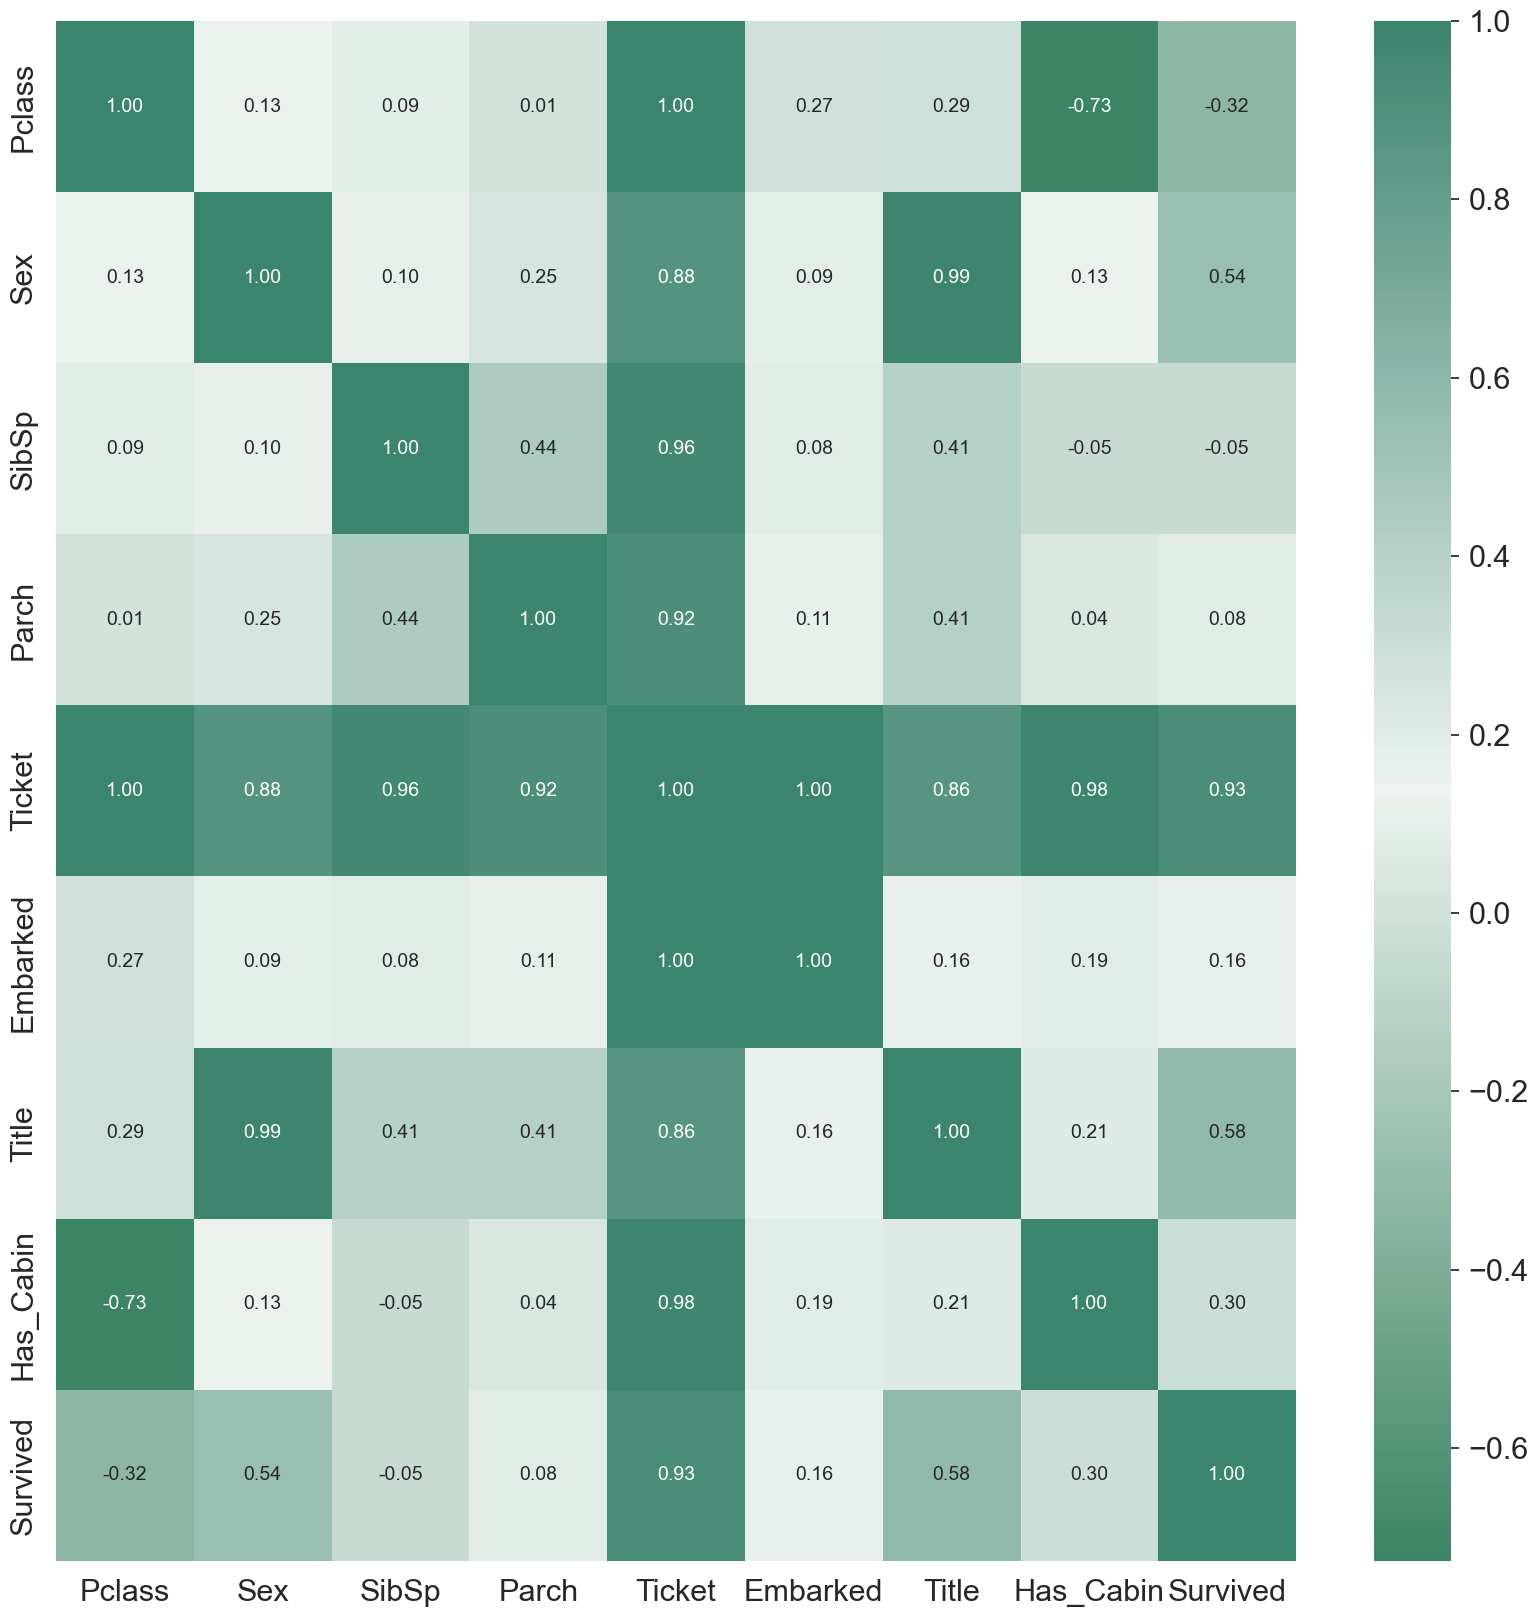

In [35]:
hitmap_df = pd.merge(X_train, y_train, left_index=True, right_index=True)
hitmap_df = de.AssociationMatrix(hitmap_df)
hitmap_df = hitmap_df.fit()
de.show_hitmap(hitmap_df)

# Model 3 

In [36]:
df = pd.read_csv('train.csv')
X = df.loc[:, df.columns != target]
y = df.loc[:, target]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
def transform_3(df):
    '''
    function that transforms training set and test set in the same way
    this specific function:
    
    - drops Passenger ID
    - creates a 'Title' feature and drops the 'Name'
    - creates 'Has Cabin' and drops 'Cabin'
    - selects features: ['Ticket', 'Title', 'Sex', 'Pclass', 'Has_Cabin']
    
    Args:
        df
        
    Returns:
        df with new features
    '''
    df.drop(['PassengerId'], axis = 1, inplace = True)
    df['Title'] = df['Name'].apply(lambda x: engineer_title(x))
    df['Title'] = df['Title'].apply(lambda x: clean_titles(x))
    df['Has_Cabin'] = df['Cabin'].apply(lambda x: engineer_cabin(x))
    df = df[['Ticket', 'Title', 'Sex', 'Pclass', 'Has_Cabin']]
    return df

In [38]:
X_train = transform_3(X_train)
X_test = transform_3(X_test)
X_train.head()

,Ticket,Title,Sex,Pclass,Has_Cabin
331,113043,Mr,male,1,1
733,28425,Mr,male,2,0
382,STON/O 2. 3101293,Mr,male,3,0
704,350025,Mr,male,3,0
813,347082,Miss,female,3,0


In [39]:
features = list(X_train.columns)
cat_features = de.get_cat_features(X_train)

model_3 = CatBoostClassifier(task_type = 'GPU', iterations = 1000, eval_metric = 'F1')
model_3.fit(X_train, y_train, cat_features = cat_features, plot = True, eval_set = (X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.073293
0:	learn: 0.6585956	test: 0.6610169	best: 0.6610169 (0)	total: 34.5ms	remaining: 34.4s
1:	learn: 0.6698565	test: 0.6610169	best: 0.6610169 (0)	total: 66.6ms	remaining: 33.2s
2:	learn: 0.6761229	test: 0.6722689	best: 0.6722689 (2)	total: 98.3ms	remaining: 32.7s
3:	learn: 0.6792453	test: 0.6610169	best: 0.6722689 (2)	total: 126ms	remaining: 31.3s
4:	learn: 0.7368421	test: 0.7482993	best: 0.7482993 (4)	total: 150ms	remaining: 29.9s
5:	learn: 0.7368421	test: 0.7482993	best: 0.7482993 (4)	total: 181ms	remaining: 30s
6:	learn: 0.7368421	test: 0.7482993	best: 0.7482993 (4)	total: 213ms	remaining: 30.2s
7:	learn: 0.7368421	test: 0.7482993	best: 0.7482993 (4)	total: 244ms	remaining: 30.2s
8:	learn: 0.7368421	test: 0.7482993	best: 0.7482993 (4)	total: 277ms	remaining: 30.5s
9:	learn: 0.7368421	test: 0.7482993	best: 0.7482993 (4)	total: 302ms	remaining: 29.9s
10:	learn: 0.7368421	test: 0.7482993	best: 0.7482993 (4)	total: 328ms	remaining: 29.5s
11:	learn: 0.7368421	t

98:	learn: 0.7821012	test: 0.8142857	best: 0.8142857 (45)	total: 2.88s	remaining: 26.2s
99:	learn: 0.7821012	test: 0.8142857	best: 0.8142857 (45)	total: 2.91s	remaining: 26.2s
100:	learn: 0.7821012	test: 0.8142857	best: 0.8142857 (45)	total: 2.94s	remaining: 26.1s
101:	learn: 0.7821012	test: 0.8142857	best: 0.8142857 (45)	total: 2.96s	remaining: 26.1s
102:	learn: 0.7821012	test: 0.8142857	best: 0.8142857 (45)	total: 2.99s	remaining: 26s
103:	learn: 0.7821012	test: 0.8201439	best: 0.8201439 (103)	total: 3.01s	remaining: 26s
104:	learn: 0.7821012	test: 0.8201439	best: 0.8201439 (103)	total: 3.04s	remaining: 25.9s
105:	learn: 0.7844660	test: 0.8201439	best: 0.8201439 (103)	total: 3.07s	remaining: 25.9s
106:	learn: 0.7844660	test: 0.8201439	best: 0.8201439 (103)	total: 3.1s	remaining: 25.9s
107:	learn: 0.7875244	test: 0.8201439	best: 0.8201439 (103)	total: 3.13s	remaining: 25.8s
108:	learn: 0.7875244	test: 0.8201439	best: 0.8201439 (103)	total: 3.15s	remaining: 25.8s
109:	learn: 0.7875244	

193:	learn: 0.7862903	test: 0.8285714	best: 0.8285714 (192)	total: 5.73s	remaining: 23.8s
194:	learn: 0.7862903	test: 0.8285714	best: 0.8285714 (192)	total: 5.76s	remaining: 23.8s
195:	learn: 0.7862903	test: 0.8201439	best: 0.8285714 (192)	total: 5.79s	remaining: 23.8s
196:	learn: 0.7862903	test: 0.8201439	best: 0.8285714 (192)	total: 5.83s	remaining: 23.7s
197:	learn: 0.7862903	test: 0.8201439	best: 0.8285714 (192)	total: 5.86s	remaining: 23.7s
198:	learn: 0.7862903	test: 0.8201439	best: 0.8285714 (192)	total: 5.89s	remaining: 23.7s
199:	learn: 0.7862903	test: 0.8201439	best: 0.8285714 (192)	total: 5.92s	remaining: 23.7s
200:	learn: 0.7878788	test: 0.8201439	best: 0.8285714 (192)	total: 5.95s	remaining: 23.7s
201:	learn: 0.7847082	test: 0.8201439	best: 0.8285714 (192)	total: 5.98s	remaining: 23.6s
202:	learn: 0.7847082	test: 0.8201439	best: 0.8285714 (192)	total: 6.01s	remaining: 23.6s
203:	learn: 0.7862903	test: 0.8201439	best: 0.8285714 (192)	total: 6.04s	remaining: 23.6s
204:	learn

287:	learn: 0.7902240	test: 0.8111888	best: 0.8285714 (192)	total: 8.61s	remaining: 21.3s
288:	learn: 0.7902240	test: 0.8111888	best: 0.8285714 (192)	total: 8.64s	remaining: 21.3s
289:	learn: 0.7902240	test: 0.8111888	best: 0.8285714 (192)	total: 8.67s	remaining: 21.2s
290:	learn: 0.7902240	test: 0.8111888	best: 0.8285714 (192)	total: 8.7s	remaining: 21.2s
291:	learn: 0.7902240	test: 0.8111888	best: 0.8285714 (192)	total: 8.73s	remaining: 21.2s
292:	learn: 0.7902240	test: 0.8111888	best: 0.8285714 (192)	total: 8.76s	remaining: 21.1s
293:	learn: 0.7902240	test: 0.8111888	best: 0.8285714 (192)	total: 8.79s	remaining: 21.1s
294:	learn: 0.7902240	test: 0.8285714	best: 0.8285714 (192)	total: 8.82s	remaining: 21.1s
295:	learn: 0.7902240	test: 0.8111888	best: 0.8285714 (192)	total: 8.85s	remaining: 21s
296:	learn: 0.7902240	test: 0.8111888	best: 0.8285714 (192)	total: 8.88s	remaining: 21s
297:	learn: 0.7902240	test: 0.8111888	best: 0.8285714 (192)	total: 8.91s	remaining: 21s
298:	learn: 0.790

382:	learn: 0.8072289	test: 0.8226950	best: 0.8285714 (192)	total: 11.5s	remaining: 18.5s
383:	learn: 0.8072289	test: 0.8226950	best: 0.8285714 (192)	total: 11.5s	remaining: 18.5s
384:	learn: 0.8072289	test: 0.8226950	best: 0.8285714 (192)	total: 11.5s	remaining: 18.4s
385:	learn: 0.8072289	test: 0.8226950	best: 0.8285714 (192)	total: 11.6s	remaining: 18.4s
386:	learn: 0.8072289	test: 0.8226950	best: 0.8285714 (192)	total: 11.6s	remaining: 18.4s
387:	learn: 0.8040404	test: 0.8226950	best: 0.8285714 (192)	total: 11.6s	remaining: 18.4s
388:	learn: 0.8040404	test: 0.8226950	best: 0.8285714 (192)	total: 11.7s	remaining: 18.3s
389:	learn: 0.8040404	test: 0.8226950	best: 0.8285714 (192)	total: 11.7s	remaining: 18.3s
390:	learn: 0.8040404	test: 0.8226950	best: 0.8285714 (192)	total: 11.7s	remaining: 18.2s
391:	learn: 0.8040404	test: 0.8226950	best: 0.8285714 (192)	total: 11.7s	remaining: 18.2s
392:	learn: 0.8040404	test: 0.8226950	best: 0.8285714 (192)	total: 11.8s	remaining: 18.2s
393:	learn

476:	learn: 0.8097166	test: 0.8226950	best: 0.8285714 (192)	total: 14.2s	remaining: 15.5s
477:	learn: 0.8097166	test: 0.8226950	best: 0.8285714 (192)	total: 14.2s	remaining: 15.5s
478:	learn: 0.8128773	test: 0.8226950	best: 0.8285714 (192)	total: 14.2s	remaining: 15.5s
479:	learn: 0.8097166	test: 0.8226950	best: 0.8285714 (192)	total: 14.2s	remaining: 15.4s
480:	learn: 0.8097166	test: 0.8226950	best: 0.8285714 (192)	total: 14.3s	remaining: 15.4s
481:	learn: 0.8097166	test: 0.8226950	best: 0.8285714 (192)	total: 14.3s	remaining: 15.4s
482:	learn: 0.8097166	test: 0.8226950	best: 0.8285714 (192)	total: 14.3s	remaining: 15.3s
483:	learn: 0.8097166	test: 0.8226950	best: 0.8285714 (192)	total: 14.4s	remaining: 15.3s
484:	learn: 0.8097166	test: 0.8226950	best: 0.8285714 (192)	total: 14.4s	remaining: 15.3s
485:	learn: 0.8097166	test: 0.8226950	best: 0.8285714 (192)	total: 14.4s	remaining: 15.2s
486:	learn: 0.8097166	test: 0.8226950	best: 0.8285714 (192)	total: 14.4s	remaining: 15.2s
487:	learn

573:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 17s	remaining: 12.6s
574:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 17s	remaining: 12.6s
575:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 17s	remaining: 12.5s
576:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 17.1s	remaining: 12.5s
577:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 17.1s	remaining: 12.5s
578:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 17.1s	remaining: 12.4s
579:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 17.1s	remaining: 12.4s
580:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 17.2s	remaining: 12.4s
581:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 17.2s	remaining: 12.4s
582:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 17.2s	remaining: 12.3s
583:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 17.3s	remaining: 12.3s
584:	learn: 0.81

669:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 19.6s	remaining: 9.66s
670:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 19.6s	remaining: 9.63s
671:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 19.7s	remaining: 9.6s
672:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 19.7s	remaining: 9.58s
673:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 19.7s	remaining: 9.55s
674:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 19.8s	remaining: 9.52s
675:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 19.8s	remaining: 9.49s
676:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 19.8s	remaining: 9.47s
677:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 19.9s	remaining: 9.44s
678:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 19.9s	remaining: 9.41s
679:	learn: 0.8112450	test: 0.8226950	best: 0.8285714 (192)	total: 19.9s	remaining: 9.39s
680:	learn:

764:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 22.5s	remaining: 6.91s
765:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 22.5s	remaining: 6.88s
766:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 22.6s	remaining: 6.85s
767:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 22.6s	remaining: 6.82s
768:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 22.6s	remaining: 6.8s
769:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 22.7s	remaining: 6.77s
770:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 22.7s	remaining: 6.74s
771:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 22.7s	remaining: 6.71s
772:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 22.7s	remaining: 6.68s
773:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 22.8s	remaining: 6.65s
774:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 22.8s	remaining: 6.62s
775:	learn:

860:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 25.4s	remaining: 4.1s
861:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 25.5s	remaining: 4.08s
862:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 25.5s	remaining: 4.05s
863:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 25.5s	remaining: 4.02s
864:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 25.6s	remaining: 3.99s
865:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 25.6s	remaining: 3.96s
866:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 25.6s	remaining: 3.93s
867:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 25.7s	remaining: 3.9s
868:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 25.7s	remaining: 3.87s
869:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 25.7s	remaining: 3.84s
870:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 25.7s	remaining: 3.81s
871:	learn: 

953:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 28.3s	remaining: 1.36s
954:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 28.3s	remaining: 1.33s
955:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 28.3s	remaining: 1.3s
956:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 28.4s	remaining: 1.27s
957:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 28.4s	remaining: 1.25s
958:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 28.4s	remaining: 1.22s
959:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 28.5s	remaining: 1.19s
960:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 28.5s	remaining: 1.16s
961:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 28.5s	remaining: 1.13s
962:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 28.6s	remaining: 1.1s
963:	learn: 0.8128773	test: 0.8055556	best: 0.8285714 (192)	total: 28.6s	remaining: 1.07s
964:	learn: 

In [40]:
print('Training Accuracy: ', f1_score(y_train, model_3.predict(X_train)))
print('Testing Accuracy: ', f1_score(y_test, model_3.predict(X_test)))

Training Accuracy:  0.8744939271255061
Testing Accuracy:  0.8285714285714285


### Even Better! Let's remove 'Has_Cabin' as it has the lowest association to the target and see if that will improve or worsen our score

# Model 4

In [41]:
df = pd.read_csv('train.csv')
X = df.loc[:, df.columns != target]
y = df.loc[:, target]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
def transform_4(df):
    '''
    function that transforms training set and test set in the same way
    this specific function:
    
    - drops Passenger ID
    - creates a 'Title' feature and drops the 'Name'
    - creates 'Has Cabin' and drops 'Cabin'
    - selects features: ['Ticket', 'Title', 'Sex', 'Pclass']
    
    Args:
        df
        
    Returns:
        df with new features
    '''
    df.drop(['PassengerId'], axis = 1, inplace = True)
    df['Title'] = df['Name'].apply(lambda x: engineer_title(x))
    df['Title'] = df['Title'].apply(lambda x: clean_titles(x))
    df['Has_Cabin'] = df['Cabin'].apply(lambda x: engineer_cabin(x))
    df = df[['Ticket', 'Title', 'Sex', 'Pclass']]
    return df

In [43]:
X_train = transform_4(X_train)
X_test = transform_4(X_test)
X_train.head()

,Ticket,Title,Sex,Pclass
331,113043,Mr,male,1
733,28425,Mr,male,2
382,STON/O 2. 3101293,Mr,male,3
704,350025,Mr,male,3
813,347082,Miss,female,3


In [44]:
features = list(X_train.columns)
cat_features = de.get_cat_features(X_train)

model_4 = CatBoostClassifier(task_type = 'GPU', iterations = 1000, eval_metric = 'F1')
model_4.fit(X_train, y_train, cat_features = cat_features, plot = True, eval_set = (X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.073293
0:	learn: 0.6666667	test: 0.6610169	best: 0.6610169 (0)	total: 35.8ms	remaining: 35.7s
1:	learn: 0.6634845	test: 0.6610169	best: 0.6610169 (0)	total: 62.8ms	remaining: 31.4s
2:	learn: 0.6776471	test: 0.6610169	best: 0.6610169 (0)	total: 94.9ms	remaining: 31.5s
3:	learn: 0.6760563	test: 0.6610169	best: 0.6610169 (0)	total: 127ms	remaining: 31.7s
4:	learn: 0.6792453	test: 0.6610169	best: 0.6610169 (0)	total: 159ms	remaining: 31.7s
5:	learn: 0.6761229	test: 0.6610169	best: 0.6610169 (0)	total: 194ms	remaining: 32.1s
6:	learn: 0.6745283	test: 0.6610169	best: 0.6610169 (0)	total: 222ms	remaining: 31.5s
7:	learn: 0.6807512	test: 0.6610169	best: 0.6610169 (0)	total: 258ms	remaining: 32s
8:	learn: 0.7022222	test: 0.6456693	best: 0.6610169 (0)	total: 285ms	remaining: 31.4s
9:	learn: 0.7022222	test: 0.6456693	best: 0.6610169 (0)	total: 317ms	remaining: 31.4s
10:	learn: 0.7035398	test: 0.6456693	best: 0.6610169 (0)	total: 348ms	remaining: 31.3s
11:	learn: 0.7006652	t

95:	learn: 0.7821012	test: 0.8142857	best: 0.8142857 (37)	total: 2.95s	remaining: 27.8s
96:	learn: 0.7821012	test: 0.8142857	best: 0.8142857 (37)	total: 2.98s	remaining: 27.7s
97:	learn: 0.7821012	test: 0.8142857	best: 0.8142857 (37)	total: 3.01s	remaining: 27.7s
98:	learn: 0.7821012	test: 0.8142857	best: 0.8142857 (37)	total: 3.04s	remaining: 27.7s
99:	learn: 0.7821012	test: 0.8142857	best: 0.8142857 (37)	total: 3.07s	remaining: 27.7s
100:	learn: 0.7821012	test: 0.8142857	best: 0.8142857 (37)	total: 3.1s	remaining: 27.6s
101:	learn: 0.7821012	test: 0.8142857	best: 0.8142857 (37)	total: 3.13s	remaining: 27.6s
102:	learn: 0.7821012	test: 0.8142857	best: 0.8142857 (37)	total: 3.17s	remaining: 27.6s
103:	learn: 0.7821012	test: 0.8142857	best: 0.8142857 (37)	total: 3.19s	remaining: 27.5s
104:	learn: 0.7836257	test: 0.8142857	best: 0.8142857 (37)	total: 3.23s	remaining: 27.5s
105:	learn: 0.7836257	test: 0.8142857	best: 0.8142857 (37)	total: 3.25s	remaining: 27.4s
106:	learn: 0.7836257	test:

190:	learn: 0.7911647	test: 0.8142857	best: 0.8142857 (37)	total: 5.65s	remaining: 24s
191:	learn: 0.7927565	test: 0.8142857	best: 0.8142857 (37)	total: 5.68s	remaining: 23.9s
192:	learn: 0.7911647	test: 0.8142857	best: 0.8142857 (37)	total: 5.71s	remaining: 23.9s
193:	learn: 0.7927565	test: 0.8142857	best: 0.8142857 (37)	total: 5.74s	remaining: 23.9s
194:	learn: 0.7927565	test: 0.8142857	best: 0.8142857 (37)	total: 5.77s	remaining: 23.8s
195:	learn: 0.7911647	test: 0.8142857	best: 0.8142857 (37)	total: 5.8s	remaining: 23.8s
196:	learn: 0.7935872	test: 0.8142857	best: 0.8142857 (37)	total: 5.83s	remaining: 23.8s
197:	learn: 0.7951807	test: 0.8142857	best: 0.8142857 (37)	total: 5.86s	remaining: 23.7s
198:	learn: 0.7951807	test: 0.8142857	best: 0.8142857 (37)	total: 5.89s	remaining: 23.7s
199:	learn: 0.7951807	test: 0.8142857	best: 0.8142857 (37)	total: 5.92s	remaining: 23.7s
200:	learn: 0.7951807	test: 0.8142857	best: 0.8142857 (37)	total: 5.95s	remaining: 23.6s
201:	learn: 0.7951807	te

288:	learn: 0.7991886	test: 0.8142857	best: 0.8142857 (37)	total: 8.68s	remaining: 21.3s
289:	learn: 0.7991886	test: 0.8142857	best: 0.8142857 (37)	total: 8.71s	remaining: 21.3s
290:	learn: 0.7991886	test: 0.8142857	best: 0.8142857 (37)	total: 8.74s	remaining: 21.3s
291:	learn: 0.7991886	test: 0.8142857	best: 0.8142857 (37)	total: 8.77s	remaining: 21.3s
292:	learn: 0.7991886	test: 0.8142857	best: 0.8142857 (37)	total: 8.8s	remaining: 21.2s
293:	learn: 0.7991886	test: 0.8142857	best: 0.8142857 (37)	total: 8.83s	remaining: 21.2s
294:	learn: 0.7991886	test: 0.8142857	best: 0.8142857 (37)	total: 8.87s	remaining: 21.2s
295:	learn: 0.8008130	test: 0.8142857	best: 0.8142857 (37)	total: 8.9s	remaining: 21.2s
296:	learn: 0.8008130	test: 0.8142857	best: 0.8142857 (37)	total: 8.93s	remaining: 21.1s
297:	learn: 0.8008130	test: 0.8142857	best: 0.8142857 (37)	total: 8.96s	remaining: 21.1s
298:	learn: 0.8008130	test: 0.8142857	best: 0.8142857 (37)	total: 9s	remaining: 21.1s
299:	learn: 0.8008130	test

381:	learn: 0.8024440	test: 0.8142857	best: 0.8142857 (37)	total: 11.8s	remaining: 19s
382:	learn: 0.8024440	test: 0.8142857	best: 0.8142857 (37)	total: 11.8s	remaining: 19s
383:	learn: 0.8024440	test: 0.8142857	best: 0.8142857 (37)	total: 11.8s	remaining: 19s
384:	learn: 0.8024440	test: 0.8142857	best: 0.8142857 (37)	total: 11.9s	remaining: 19s
385:	learn: 0.8024440	test: 0.8142857	best: 0.8142857 (37)	total: 11.9s	remaining: 18.9s
386:	learn: 0.8024440	test: 0.8142857	best: 0.8142857 (37)	total: 11.9s	remaining: 18.9s
387:	learn: 0.8024440	test: 0.8142857	best: 0.8142857 (37)	total: 12s	remaining: 18.9s
388:	learn: 0.8040816	test: 0.8142857	best: 0.8142857 (37)	total: 12s	remaining: 18.9s
389:	learn: 0.8040816	test: 0.8142857	best: 0.8142857 (37)	total: 12.1s	remaining: 18.9s
390:	learn: 0.8040816	test: 0.8142857	best: 0.8142857 (37)	total: 12.1s	remaining: 18.8s
391:	learn: 0.8040816	test: 0.8142857	best: 0.8142857 (37)	total: 12.1s	remaining: 18.8s
392:	learn: 0.8040816	test: 0.814

476:	learn: 0.8089431	test: 0.8226950	best: 0.8226950 (432)	total: 14.8s	remaining: 16.2s
477:	learn: 0.8097166	test: 0.8226950	best: 0.8226950 (432)	total: 14.8s	remaining: 16.2s
478:	learn: 0.8097166	test: 0.8226950	best: 0.8226950 (432)	total: 14.9s	remaining: 16.2s
479:	learn: 0.8097166	test: 0.8226950	best: 0.8226950 (432)	total: 14.9s	remaining: 16.1s
480:	learn: 0.8097166	test: 0.8226950	best: 0.8226950 (432)	total: 14.9s	remaining: 16.1s
481:	learn: 0.8097166	test: 0.8226950	best: 0.8226950 (432)	total: 14.9s	remaining: 16.1s
482:	learn: 0.8097166	test: 0.8226950	best: 0.8226950 (432)	total: 15s	remaining: 16s
483:	learn: 0.8097166	test: 0.8226950	best: 0.8226950 (432)	total: 15s	remaining: 16s
484:	learn: 0.8097166	test: 0.8226950	best: 0.8226950 (432)	total: 15s	remaining: 16s
485:	learn: 0.8089431	test: 0.8226950	best: 0.8226950 (432)	total: 15.1s	remaining: 15.9s
486:	learn: 0.8097166	test: 0.8226950	best: 0.8226950 (432)	total: 15.1s	remaining: 15.9s
487:	learn: 0.8097166	

574:	learn: 0.8104839	test: 0.8226950	best: 0.8226950 (432)	total: 17.8s	remaining: 13.1s
575:	learn: 0.8104839	test: 0.8226950	best: 0.8226950 (432)	total: 17.8s	remaining: 13.1s
576:	learn: 0.8104839	test: 0.8226950	best: 0.8226950 (432)	total: 17.8s	remaining: 13.1s
577:	learn: 0.8104839	test: 0.8226950	best: 0.8226950 (432)	total: 17.9s	remaining: 13s
578:	learn: 0.8104839	test: 0.8226950	best: 0.8226950 (432)	total: 17.9s	remaining: 13s
579:	learn: 0.8104839	test: 0.8226950	best: 0.8226950 (432)	total: 17.9s	remaining: 13s
580:	learn: 0.8104839	test: 0.8226950	best: 0.8226950 (432)	total: 18s	remaining: 13s
581:	learn: 0.8104839	test: 0.8226950	best: 0.8226950 (432)	total: 18s	remaining: 12.9s
582:	learn: 0.8104839	test: 0.8226950	best: 0.8226950 (432)	total: 18s	remaining: 12.9s
583:	learn: 0.8104839	test: 0.8226950	best: 0.8226950 (432)	total: 18.1s	remaining: 12.9s
584:	learn: 0.8104839	test: 0.8226950	best: 0.8226950 (432)	total: 18.1s	remaining: 12.8s
585:	learn: 0.8104839	te

671:	learn: 0.8161616	test: 0.8055556	best: 0.8226950 (432)	total: 20.8s	remaining: 10.2s
672:	learn: 0.8161616	test: 0.8055556	best: 0.8226950 (432)	total: 20.8s	remaining: 10.1s
673:	learn: 0.8145161	test: 0.8055556	best: 0.8226950 (432)	total: 20.9s	remaining: 10.1s
674:	learn: 0.8145161	test: 0.8055556	best: 0.8226950 (432)	total: 20.9s	remaining: 10.1s
675:	learn: 0.8161616	test: 0.8055556	best: 0.8226950 (432)	total: 21s	remaining: 10s
676:	learn: 0.8145161	test: 0.8055556	best: 0.8226950 (432)	total: 21s	remaining: 10s
677:	learn: 0.8145161	test: 0.8055556	best: 0.8226950 (432)	total: 21s	remaining: 9.99s
678:	learn: 0.8145161	test: 0.8055556	best: 0.8226950 (432)	total: 21.1s	remaining: 9.96s
679:	learn: 0.8145161	test: 0.8055556	best: 0.8226950 (432)	total: 21.1s	remaining: 9.93s
680:	learn: 0.8145161	test: 0.8055556	best: 0.8226950 (432)	total: 21.1s	remaining: 9.9s
681:	learn: 0.8145161	test: 0.8055556	best: 0.8226950 (432)	total: 21.2s	remaining: 9.87s
682:	learn: 0.8145161

764:	learn: 0.8137652	test: 0.7972028	best: 0.8226950 (432)	total: 23.8s	remaining: 7.3s
765:	learn: 0.8137652	test: 0.7972028	best: 0.8226950 (432)	total: 23.8s	remaining: 7.27s
766:	learn: 0.8137652	test: 0.7972028	best: 0.8226950 (432)	total: 23.8s	remaining: 7.24s
767:	learn: 0.8137652	test: 0.7972028	best: 0.8226950 (432)	total: 23.9s	remaining: 7.21s
768:	learn: 0.8137652	test: 0.7972028	best: 0.8226950 (432)	total: 23.9s	remaining: 7.17s
769:	learn: 0.8137652	test: 0.7972028	best: 0.8226950 (432)	total: 23.9s	remaining: 7.14s
770:	learn: 0.8137652	test: 0.7972028	best: 0.8226950 (432)	total: 23.9s	remaining: 7.11s
771:	learn: 0.8137652	test: 0.7972028	best: 0.8226950 (432)	total: 24s	remaining: 7.08s
772:	learn: 0.8137652	test: 0.7972028	best: 0.8226950 (432)	total: 24s	remaining: 7.05s
773:	learn: 0.8137652	test: 0.7972028	best: 0.8226950 (432)	total: 24s	remaining: 7.02s
774:	learn: 0.8137652	test: 0.7972028	best: 0.8226950 (432)	total: 24.1s	remaining: 6.99s
775:	learn: 0.813

856:	learn: 0.8121212	test: 0.7972028	best: 0.8226950 (432)	total: 26.6s	remaining: 4.43s
857:	learn: 0.8121212	test: 0.7972028	best: 0.8226950 (432)	total: 26.6s	remaining: 4.4s
858:	learn: 0.8121212	test: 0.7972028	best: 0.8226950 (432)	total: 26.6s	remaining: 4.37s
859:	learn: 0.8121212	test: 0.7972028	best: 0.8226950 (432)	total: 26.7s	remaining: 4.34s
860:	learn: 0.8121212	test: 0.7972028	best: 0.8226950 (432)	total: 26.7s	remaining: 4.31s
861:	learn: 0.8121212	test: 0.7972028	best: 0.8226950 (432)	total: 26.7s	remaining: 4.28s
862:	learn: 0.8121212	test: 0.7972028	best: 0.8226950 (432)	total: 26.8s	remaining: 4.25s
863:	learn: 0.8121212	test: 0.7972028	best: 0.8226950 (432)	total: 26.8s	remaining: 4.21s
864:	learn: 0.8121212	test: 0.7972028	best: 0.8226950 (432)	total: 26.8s	remaining: 4.18s
865:	learn: 0.8121212	test: 0.7972028	best: 0.8226950 (432)	total: 26.8s	remaining: 4.15s
866:	learn: 0.8121212	test: 0.7972028	best: 0.8226950 (432)	total: 26.9s	remaining: 4.12s
867:	learn:

956:	learn: 0.8137652	test: 0.7972028	best: 0.8226950 (432)	total: 29.5s	remaining: 1.32s
957:	learn: 0.8137652	test: 0.7972028	best: 0.8226950 (432)	total: 29.5s	remaining: 1.29s
958:	learn: 0.8137652	test: 0.7972028	best: 0.8226950 (432)	total: 29.5s	remaining: 1.26s
959:	learn: 0.8137652	test: 0.7972028	best: 0.8226950 (432)	total: 29.6s	remaining: 1.23s
960:	learn: 0.8137652	test: 0.7972028	best: 0.8226950 (432)	total: 29.6s	remaining: 1.2s
961:	learn: 0.8137652	test: 0.7972028	best: 0.8226950 (432)	total: 29.6s	remaining: 1.17s
962:	learn: 0.8137652	test: 0.7972028	best: 0.8226950 (432)	total: 29.6s	remaining: 1.14s
963:	learn: 0.8137652	test: 0.8142857	best: 0.8226950 (432)	total: 29.7s	remaining: 1.11s
964:	learn: 0.8137652	test: 0.8142857	best: 0.8226950 (432)	total: 29.7s	remaining: 1.08s
965:	learn: 0.8137652	test: 0.8142857	best: 0.8226950 (432)	total: 29.7s	remaining: 1.04s
966:	learn: 0.8137652	test: 0.8142857	best: 0.8226950 (432)	total: 29.7s	remaining: 1.01s
967:	learn:

In [45]:
print('Training Accuracy: ', f1_score(y_train, model_4.predict(X_train)))
print('Testing Accuracy: ', f1_score(y_test, model_4.predict(X_test)))

Training Accuracy:  0.8709677419354839
Testing Accuracy:  0.8226950354609929


### That seem tiny bit worse

# DECISION: selected features: ['Ticket', 'Title', 'Sex', 'Pclass', 'Has_Cabin']

<div class="alert-success" style="margin-top: 0px">
<h1> Oversampling to combat class imballance </h1>
</div>

# Model 5

In [46]:
df = pd.read_csv('train.csv')
X = df.copy()
y = df.loc[:, target]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# separate minority and majority classes
died = X[X.Survived==0]
survived = X[X.Survived==1]

# oversample minority
oversampled = resample(survived,
          replace=True, # sample with replacement
          n_samples=len(died), # match number in majority class
          random_state=0) # reproducible results

# combine majority and oversampled minority
oversampled = pd.concat([died, oversampled])

# replace training set with oversampled
y_train = oversampled.Survived
X_train = oversampled.drop('Survived', axis=1)

# view class balance
y_train.value_counts()

0    549
1    549
Name: Survived, dtype: int64

In [47]:
X_train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
440,441,2,"Hart, Mrs. Benjamin (Esther Ada Bloomfield)",female,45.0,1,1,F.C.C. 13529,26.2500,NaN,S
543,544,2,"Beane, Mr. Edward",male,32.0,1,0,2908,26.0000,NaN,S
207,208,3,"Albimona, Mr. Nassef Cassem",male,26.0,0,0,2699,18.7875,NaN,C
381,382,3,"Nakid, Miss. Maria (""Mary"")",female,1.0,0,2,2653,15.7417,NaN,C


In [48]:
X_train = X_train.loc[:, X_train.columns != target]
X_train = transform_3(X_train)
X_test = X_test.loc[:, X_test.columns != target]
X_test = transform_3(X_test)
X_train.head()

,Ticket,Title,Sex,Pclass,Has_Cabin
0,A/5 21171,Mr,male,3,0
4,373450,Mr,male,3,0
5,330877,Mr,male,3,0
6,17463,Mr,male,1,1
7,349909,Master,male,3,0


In [49]:
features = list(X_train.columns)
cat_features = de.get_cat_features(X_train)

model_5 = CatBoostClassifier(task_type = 'GPU', iterations = 1000, eval_metric = 'F1')
model_5.fit(X_train, y_train, cat_features = cat_features, plot = True, eval_set = (X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.070644
0:	learn: 0.7888372	test: 0.7631579	best: 0.7631579 (0)	total: 31.8ms	remaining: 31.8s
1:	learn: 0.7910448	test: 0.7631579	best: 0.7631579 (0)	total: 64.2ms	remaining: 32.1s
2:	learn: 0.7925234	test: 0.7631579	best: 0.7631579 (0)	total: 95.8ms	remaining: 31.8s
3:	learn: 0.8287972	test: 0.7826087	best: 0.7826087 (3)	total: 120ms	remaining: 30s
4:	learn: 0.8241659	test: 0.7924528	best: 0.7924528 (4)	total: 150ms	remaining: 29.8s
5:	learn: 0.8420074	test: 0.7733333	best: 0.7924528 (4)	total: 181ms	remaining: 30s
6:	learn: 0.8438662	test: 0.7733333	best: 0.7924528 (4)	total: 214ms	remaining: 30.3s
7:	learn: 0.8636797	test: 0.8345324	best: 0.8345324 (7)	total: 247ms	remaining: 30.6s
8:	learn: 0.8645038	test: 0.8345324	best: 0.8345324 (7)	total: 288ms	remaining: 31.7s
9:	learn: 0.8936170	test: 0.8671329	best: 0.8671329 (9)	total: 327ms	remaining: 32.4s
10:	learn: 0.8990654	test: 0.8794326	best: 0.8794326 (10)	total: 367ms	remaining: 33s
11:	learn: 0.8997188	test

96:	learn: 0.9233610	test: 0.9117647	best: 0.9117647 (45)	total: 3.08s	remaining: 28.7s
97:	learn: 0.9233610	test: 0.9117647	best: 0.9117647 (45)	total: 3.11s	remaining: 28.6s
98:	learn: 0.9233610	test: 0.9117647	best: 0.9117647 (45)	total: 3.14s	remaining: 28.6s
99:	learn: 0.9233610	test: 0.9117647	best: 0.9117647 (45)	total: 3.17s	remaining: 28.5s
100:	learn: 0.9233610	test: 0.9117647	best: 0.9117647 (45)	total: 3.2s	remaining: 28.5s
101:	learn: 0.9233610	test: 0.9117647	best: 0.9117647 (45)	total: 3.23s	remaining: 28.4s
102:	learn: 0.9223660	test: 0.9117647	best: 0.9117647 (45)	total: 3.27s	remaining: 28.4s
103:	learn: 0.9223660	test: 0.9117647	best: 0.9117647 (45)	total: 3.3s	remaining: 28.4s
104:	learn: 0.9223660	test: 0.9117647	best: 0.9117647 (45)	total: 3.33s	remaining: 28.4s
105:	learn: 0.9223660	test: 0.9117647	best: 0.9117647 (45)	total: 3.36s	remaining: 28.4s
106:	learn: 0.9223660	test: 0.9117647	best: 0.9117647 (45)	total: 3.4s	remaining: 28.3s
107:	learn: 0.9243542	test: 

191:	learn: 0.9302326	test: 0.9117647	best: 0.9117647 (45)	total: 5.92s	remaining: 24.9s
192:	learn: 0.9302326	test: 0.9117647	best: 0.9117647 (45)	total: 5.95s	remaining: 24.9s
193:	learn: 0.9302326	test: 0.9117647	best: 0.9117647 (45)	total: 5.98s	remaining: 24.8s
194:	learn: 0.9302326	test: 0.9117647	best: 0.9117647 (45)	total: 6.01s	remaining: 24.8s
195:	learn: 0.9302326	test: 0.9117647	best: 0.9117647 (45)	total: 6.04s	remaining: 24.8s
196:	learn: 0.9302326	test: 0.9117647	best: 0.9117647 (45)	total: 6.07s	remaining: 24.7s
197:	learn: 0.9302326	test: 0.9117647	best: 0.9117647 (45)	total: 6.1s	remaining: 24.7s
198:	learn: 0.9302326	test: 0.9117647	best: 0.9117647 (45)	total: 6.13s	remaining: 24.7s
199:	learn: 0.9302326	test: 0.9117647	best: 0.9117647 (45)	total: 6.16s	remaining: 24.6s
200:	learn: 0.9302326	test: 0.9117647	best: 0.9117647 (45)	total: 6.19s	remaining: 24.6s
201:	learn: 0.9302326	test: 0.9117647	best: 0.9117647 (45)	total: 6.22s	remaining: 24.6s
202:	learn: 0.9302326	

291:	learn: 0.9330855	test: 0.9197080	best: 0.9275362 (277)	total: 9.02s	remaining: 21.9s
292:	learn: 0.9322191	test: 0.9275362	best: 0.9275362 (277)	total: 9.04s	remaining: 21.8s
293:	learn: 0.9322191	test: 0.9275362	best: 0.9275362 (277)	total: 9.07s	remaining: 21.8s
294:	learn: 0.9329609	test: 0.9275362	best: 0.9275362 (277)	total: 9.1s	remaining: 21.7s
295:	learn: 0.9329609	test: 0.9275362	best: 0.9275362 (277)	total: 9.13s	remaining: 21.7s
296:	learn: 0.9329609	test: 0.9275362	best: 0.9275362 (277)	total: 9.16s	remaining: 21.7s
297:	learn: 0.9329609	test: 0.9275362	best: 0.9275362 (277)	total: 9.18s	remaining: 21.6s
298:	learn: 0.9329609	test: 0.9275362	best: 0.9275362 (277)	total: 9.21s	remaining: 21.6s
299:	learn: 0.9322191	test: 0.9275362	best: 0.9275362 (277)	total: 9.24s	remaining: 21.6s
300:	learn: 0.9322191	test: 0.9275362	best: 0.9275362 (277)	total: 9.26s	remaining: 21.5s
301:	learn: 0.9329609	test: 0.9275362	best: 0.9275362 (277)	total: 9.3s	remaining: 21.5s
302:	learn: 

383:	learn: 0.9349442	test: 0.9197080	best: 0.9275362 (277)	total: 11.8s	remaining: 19s
384:	learn: 0.9349442	test: 0.9197080	best: 0.9275362 (277)	total: 11.9s	remaining: 19s
385:	learn: 0.9349442	test: 0.9197080	best: 0.9275362 (277)	total: 11.9s	remaining: 19s
386:	learn: 0.9349442	test: 0.9197080	best: 0.9275362 (277)	total: 11.9s	remaining: 18.9s
387:	learn: 0.9349442	test: 0.9197080	best: 0.9275362 (277)	total: 12s	remaining: 18.9s
388:	learn: 0.9349442	test: 0.9197080	best: 0.9275362 (277)	total: 12s	remaining: 18.9s
389:	learn: 0.9349442	test: 0.9197080	best: 0.9275362 (277)	total: 12s	remaining: 18.8s
390:	learn: 0.9349442	test: 0.9197080	best: 0.9275362 (277)	total: 12.1s	remaining: 18.8s
391:	learn: 0.9349442	test: 0.9197080	best: 0.9275362 (277)	total: 12.1s	remaining: 18.8s
392:	learn: 0.9349442	test: 0.9197080	best: 0.9275362 (277)	total: 12.1s	remaining: 18.7s
393:	learn: 0.9349442	test: 0.9197080	best: 0.9275362 (277)	total: 12.2s	remaining: 18.7s
394:	learn: 0.9349442	

480:	learn: 0.9365672	test: 0.9197080	best: 0.9275362 (277)	total: 15s	remaining: 16.2s
481:	learn: 0.9365672	test: 0.9197080	best: 0.9275362 (277)	total: 15s	remaining: 16.1s
482:	learn: 0.9365672	test: 0.9197080	best: 0.9275362 (277)	total: 15.1s	remaining: 16.1s
483:	learn: 0.9365672	test: 0.9197080	best: 0.9275362 (277)	total: 15.1s	remaining: 16.1s
484:	learn: 0.9365672	test: 0.9197080	best: 0.9275362 (277)	total: 15.1s	remaining: 16.1s
485:	learn: 0.9365672	test: 0.9197080	best: 0.9275362 (277)	total: 15.2s	remaining: 16s
486:	learn: 0.9365672	test: 0.9197080	best: 0.9275362 (277)	total: 15.2s	remaining: 16s
487:	learn: 0.9365672	test: 0.9197080	best: 0.9275362 (277)	total: 15.2s	remaining: 16s
488:	learn: 0.9365672	test: 0.9197080	best: 0.9275362 (277)	total: 15.3s	remaining: 16s
489:	learn: 0.9365672	test: 0.9197080	best: 0.9275362 (277)	total: 15.3s	remaining: 15.9s
490:	learn: 0.9365672	test: 0.9197080	best: 0.9275362 (277)	total: 15.3s	remaining: 15.9s
491:	learn: 0.9365672	

573:	learn: 0.9404097	test: 0.9197080	best: 0.9275362 (277)	total: 17.8s	remaining: 13.2s
574:	learn: 0.9405204	test: 0.9197080	best: 0.9275362 (277)	total: 17.9s	remaining: 13.2s
575:	learn: 0.9405204	test: 0.9197080	best: 0.9275362 (277)	total: 17.9s	remaining: 13.2s
576:	learn: 0.9405204	test: 0.9197080	best: 0.9275362 (277)	total: 17.9s	remaining: 13.1s
577:	learn: 0.9405204	test: 0.9197080	best: 0.9275362 (277)	total: 18s	remaining: 13.1s
578:	learn: 0.9405204	test: 0.9197080	best: 0.9275362 (277)	total: 18s	remaining: 13.1s
579:	learn: 0.9405204	test: 0.9197080	best: 0.9275362 (277)	total: 18s	remaining: 13s
580:	learn: 0.9405204	test: 0.9197080	best: 0.9275362 (277)	total: 18s	remaining: 13s
581:	learn: 0.9405204	test: 0.9197080	best: 0.9275362 (277)	total: 18.1s	remaining: 13s
582:	learn: 0.9405204	test: 0.9197080	best: 0.9275362 (277)	total: 18.1s	remaining: 12.9s
583:	learn: 0.9405204	test: 0.9197080	best: 0.9275362 (277)	total: 18.1s	remaining: 12.9s
584:	learn: 0.9405204	te

670:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 20.8s	remaining: 10.2s
671:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 20.8s	remaining: 10.2s
672:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 20.9s	remaining: 10.1s
673:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 20.9s	remaining: 10.1s
674:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 20.9s	remaining: 10.1s
675:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 21s	remaining: 10s
676:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 21s	remaining: 10s
677:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 21s	remaining: 9.98s
678:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 21.1s	remaining: 9.95s
679:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 21.1s	remaining: 9.92s
680:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 21.1s	remaining: 9.89s
681:	learn: 0.941504

766:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 24s	remaining: 7.3s
767:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 24.1s	remaining: 7.27s
768:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 24.1s	remaining: 7.24s
769:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 24.1s	remaining: 7.21s
770:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 24.2s	remaining: 7.17s
771:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 24.2s	remaining: 7.14s
772:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 24.2s	remaining: 7.11s
773:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 24.2s	remaining: 7.08s
774:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 24.3s	remaining: 7.04s
775:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 24.3s	remaining: 7.01s
776:	learn: 0.9415042	test: 0.9197080	best: 0.9275362 (277)	total: 24.3s	remaining: 6.98s
777:	learn: 0

862:	learn: 0.9442379	test: 0.9197080	best: 0.9275362 (277)	total: 26.9s	remaining: 4.27s
863:	learn: 0.9442379	test: 0.9197080	best: 0.9275362 (277)	total: 26.9s	remaining: 4.24s
864:	learn: 0.9442379	test: 0.9197080	best: 0.9275362 (277)	total: 27s	remaining: 4.21s
865:	learn: 0.9442379	test: 0.9197080	best: 0.9275362 (277)	total: 27s	remaining: 4.18s
866:	learn: 0.9443414	test: 0.9197080	best: 0.9275362 (277)	total: 27.1s	remaining: 4.15s
867:	learn: 0.9434662	test: 0.9197080	best: 0.9275362 (277)	total: 27.1s	remaining: 4.12s
868:	learn: 0.9434662	test: 0.9197080	best: 0.9275362 (277)	total: 27.1s	remaining: 4.09s
869:	learn: 0.9434662	test: 0.9197080	best: 0.9275362 (277)	total: 27.2s	remaining: 4.06s
870:	learn: 0.9434662	test: 0.9197080	best: 0.9275362 (277)	total: 27.2s	remaining: 4.03s
871:	learn: 0.9434662	test: 0.9197080	best: 0.9275362 (277)	total: 27.2s	remaining: 4s
872:	learn: 0.9434662	test: 0.9197080	best: 0.9275362 (277)	total: 27.2s	remaining: 3.96s
873:	learn: 0.943

960:	learn: 0.9442379	test: 0.9197080	best: 0.9275362 (277)	total: 30s	remaining: 1.22s
961:	learn: 0.9442379	test: 0.9197080	best: 0.9275362 (277)	total: 30.1s	remaining: 1.19s
962:	learn: 0.9442379	test: 0.9197080	best: 0.9275362 (277)	total: 30.1s	remaining: 1.16s
963:	learn: 0.9442379	test: 0.9197080	best: 0.9275362 (277)	total: 30.1s	remaining: 1.13s
964:	learn: 0.9442379	test: 0.9197080	best: 0.9275362 (277)	total: 30.2s	remaining: 1.09s
965:	learn: 0.9442379	test: 0.9197080	best: 0.9275362 (277)	total: 30.2s	remaining: 1.06s
966:	learn: 0.9442379	test: 0.9197080	best: 0.9275362 (277)	total: 30.2s	remaining: 1.03s
967:	learn: 0.9442379	test: 0.9197080	best: 0.9275362 (277)	total: 30.3s	remaining: 1s
968:	learn: 0.9442379	test: 0.9197080	best: 0.9275362 (277)	total: 30.3s	remaining: 970ms
969:	learn: 0.9442379	test: 0.9197080	best: 0.9275362 (277)	total: 30.3s	remaining: 938ms
970:	learn: 0.9442379	test: 0.9197080	best: 0.9275362 (277)	total: 30.4s	remaining: 907ms
971:	learn: 0.9

In [50]:
print('Training Accuracy: ', f1_score(y_train, model_5.predict(X_train)))
print('Testing Accuracy: ', f1_score(y_test, model_5.predict(X_test)))

Training Accuracy:  0.9741697416974169
Testing Accuracy:  0.927536231884058


<div class="alert-success" style="margin-top: 0px">
<h1> Predictions </h1>
</div>  

In [51]:
evaluation_df = pd.read_csv('test.csv')
evaluation_set = transform_3(evaluation_df)
predictions = model_5.predict(evaluation_set)

In [52]:
predictions

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [53]:
evaluation_df = pd.read_csv('test.csv')

In [54]:
evaluation_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [55]:
submission = pd.DataFrame()
submission['PassengerId'] = evaluation_df['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission['Survived'] = submission['Survived'].astype(int)


# Are our test and submission dataframes the same length?
if len(submission) == len(predictions):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
    submission.to_csv('Titanic submission.csv', index=False)
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")
    
submission.head(7)    

Submission dataframe is the same length as test (418 rows).


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0


## This notebook (part 1) has only catboost model, and achieved actual ccuracy of 0.81339
### In (part 2) I explored other classification models - however this one has the best score